In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore, Accuracy

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

# Settings

In [4]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 16

GEN_IN_CHANNELS = 1
GEN_N_CLASSES = 1

DIS_IN_CHANNELS = 1
DIS_N_CLASSES = 2

E_IN_CHANNELS = 1
E_N_CLASSES = 2

EPOCH = 200

### Model Settings

#### encoder

In [5]:
ENCODER = "resnet152"
ENCODER_WEIGHT = None

#### decoder

In [6]:
DECODER_ATT = "scse"

#### head

In [7]:
GEN_ACT = "sigmoid"
DIS_ACT = "softmax"
E_ACT = "softmax"

### Optimizer Settings

In [8]:
GEN_OPTIM_NAME = "adam"
GEN_init_lr = 1e-4
GEN_momentum = 0.9

In [9]:
DIS_OPTIM_NAME = "adam"
DIS_init_lr = 1e-3
DIS_momentum = 0.9
DIS_scheduler = "cosineAnnWarm"

In [10]:
E_OPTIM_NAME = "adam"
E_init_lr = 1e-3
E_momentum = 0.9
E_scheduler = "cosineAnnWarm"

# Epochs

In [11]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR, SNR, ContourEval
from codes.activation import Activation
from codes.utils import hu_clip_tensor
from codes.losses import PerceptualLoss
from kornia.filters.sobel import Sobel

In [12]:
def set_requires_grad(nets, requires_grad=False):
    """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
    nets (network list)   -- a list of networks
    requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

In [13]:
def replace_relu_to_leakyReLU(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, nn.LeakyReLU())
        else:
            replace_relu_to_leakyReLU(child)

In [14]:
def replace_bn_to_instanceNorm(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.BatchNorm2d):
            bn = getattr(model, child_name)
            setattr(model, child_name, nn.InstanceNorm2d(bn.num_features))
        else:
            replace_bn_to_instanceNorm(child)

In [15]:
perceptual_ext = PerceptualLoss()

In [16]:
sobel_filter = Sobel().to(device)

In [17]:
def train_a2b_epoch(generator, gen_optim, 
                    tf_discriminator, tf_d_optim, tf_scheduler, 
                    edge_discriminator, edge_d_optim, edge_scheduler, 
                    dataloader, device):

    # change mode to train and move to current device
    generator = generator.eval().to(device)
    tf_discriminator = tf_discriminator.train().to(device)
    edge_discriminator = edge_discriminator.train().to(device)
    
    tf_dis_l = 0
    edge_dis_l = 0
    tf_gen_l = 0
    edge_gen_l = 0

    set_requires_grad(tf_discriminator, True)
    set_requires_grad(edge_discriminator, True)
    set_requires_grad(generator, False)
    
    iteration = len(dataloader)
    
    for index, data in tqdm(enumerate(dataloader)):
        torch.cuda.empty_cache()
        
        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
       ############################
        # (1) Update True/Fake D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        tf_d_optim.zero_grad()

        y_cls = tf_discriminator(y)
        y_pr_cls = tf_discriminator(y_pr.detach())
        
        tf_dis = nn.CrossEntropyLoss()(y_cls.float(), torch.zeros(y_cls.size()[0], dtype=torch.long, device=device)) + \
                                nn.CrossEntropyLoss()(y_pr_cls.float(), torch.ones(y_pr_cls.size()[0], dtype=torch.long, device=device))

        tf_dis.backward()
        tf_d_optim.step()
        tf_scheduler.step(EPOCH + index / iteration)
        
       ############################
        # (1.1) Update Edge D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################        
        edge_d_optim.zero_grad()        
 
        edge_y_cls = edge_discriminator(edge_y)
        edge_pr_cls = edge_discriminator(edge_y_pr.detach())
        
        edge_dis = nn.CrossEntropyLoss()(edge_y_cls.float(), torch.zeros(edge_y_cls.size()[0], dtype=torch.long, device=device)) + \
                                nn.CrossEntropyLoss()(edge_pr_cls.float(), torch.ones(edge_pr_cls.size()[0], dtype=torch.long, device=device))

        edge_dis.backward()
        edge_d_optim.step()       
        edge_scheduler.step(EPOCH + index / iteration)
        
        tf_dis_l += tf_dis.item()
        edge_dis_l += edge_dis.item()

        
    ############################
    # (2) Update G network: maximize log(D(G(z)))
    ###########################
    
    # change mode to train and move to current device
    generator = generator.train().to(device)
    tf_discriminator = tf_discriminator.eval().to(device)
    edge_discriminator = edge_discriminator.eval().to(device)
    
    air_l = 0
    bone_l = 0
    
    set_requires_grad(tf_discriminator, False)
    set_requires_grad(edge_discriminator, False)
    set_requires_grad(generator, True)
        
    for index, data in tqdm(enumerate(dataloader)):
        torch.cuda.empty_cache()
        
        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)

        gen_optim.zero_grad()

        # adversarial loss
        assert y_pr.requires_grad, "ct_pred without gradient"
        assert edge_y_pr.requires_grad, "edge without gradient"
        
        y_pr_cls = tf_discriminator(y_pr)
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        tf_gen = nn.CrossEntropyLoss()(y_pr_cls.float(), torch.zeros(y_pr_cls.size()[0], dtype=torch.long, device=device))
        
        edge_pr_cls = edge_discriminator(edge_y_pr)
        edge_pr_cls = Activation(name=DIS_ACT)(edge_pr_cls)        
        edge_gen = nn.CrossEntropyLoss()(edge_pr_cls.float(), torch.zeros(y_pr_cls.size()[0], dtype=torch.long, device=device))
        
        # auxilary loss
        # https://discuss.pytorch.org/t/unclear-about-weighted-bce-loss/21486/2
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        air_loss = nn.BCELoss()(air_pr.float(), air_x.float())
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        bone_loss = nn.BCELoss()(bone_pr.float(), bone_x.float())

        _loss = tf_gen + edge_gen + air_loss + bone_loss
        _loss.backward()    
        gen_optim.step()

        edge_gen_l += edge_gen.item()
        tf_gen_l += tf_gen.item()
        air_l += air_loss.item()
        bone_l += bone_loss.item()
        
    return  air_l/(index+1), bone_l/(index+1), edge_gen_l/(index+1), tf_gen_l/(index+1), edge_dis_l/(index+1), tf_dis_l/(index+1)

In [18]:
@torch.no_grad()
def eval_epoch(generator, tf_discriminator, edge_discriminator, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.eval().to(device)
    tf_discriminator = tf_discriminator.eval().to(device)
    edge_discriminator = edge_discriminator.eval().to(device)
    
    ssim_ = []
    psnr_ = []
    mae_ = []
    snr_ = []
    
    air_ = []
    bone_ = []
    cont_ = []
 
    tf_acc = []
    edge_acc = []
    
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
        total = x.size()[0]
       ############################
        # (1) Eval True/Fake D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################        
        y_cls = tf_discriminator(y)
        y_cls = Activation(name=DIS_ACT)(y_cls)
        y_pr_cls = tf_discriminator(y_pr)
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
           
        _, y_cls = torch.max(y_cls.data, 1)
        correct = (y_cls == torch.zeros(total, dtype=torch.long, device=y_cls.device)).sum().item()
        tf_acc += [correct / total]
        _, y_pr_cls = torch.max(y_pr_cls.data, 1)
        correct = (y_pr_cls == torch.ones(total, dtype=torch.long, device=y_cls.device)).sum().item()
        tf_acc += [correct / total]
        
       ############################
        # (1.1) Eval Edge D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################  
        edge_y_cls = edge_discriminator(edge_y)
        edge_y_cls = Activation(name=DIS_ACT)(edge_y_cls)
        edge_pr_cls = edge_discriminator(edge_y_pr)
        edge_pr_cls = Activation(name=DIS_ACT)(edge_pr_cls)

        _, edge_y_cls = torch.max(edge_y_cls.data, 1)
        correct = (edge_y_cls == torch.zeros(total, dtype=torch.long, device=edge_y_cls.device)).sum().item()
        edge_acc += [correct / total]
        _, edge_pr_cls = torch.max(edge_pr_cls.data, 1)
        correct = (edge_pr_cls == torch.ones(total, dtype=torch.long, device=edge_pr_cls.device)).sum().item()
        edge_acc += [correct / total]        
        
        ############################
        # (2) Eval G network: maximize log(D(G(z)))
        ###########################
        
        # main
        _ssim = ssim(y, y_pr, data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(y_pr, y, 1.0)
        _snr = SNR()(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())

        ssim_ += [_ssim.item()]
        psnr_ += [_psnr.item()]
        mae_ += [_mae.item()]
        snr_ += [_snr.item()]
        
        # auxilary
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(air_pr, air_x)
        air_ += [dice.item()]
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(bone_pr, bone_x)
        bone_ += [dice.item()]

        for b in range(x.size()[0]):
            cont = ContourEval()(y_pr[b, :, :, :], x[b, :, :, :])
            cont_ += [cont.item()]

    return  sum(ssim_)/len(ssim_), sum(psnr_)/len(psnr_), sum(snr_)/len(snr_), sum(mae_)/len(mae_), \
                    sum(air_)/len(air_), sum(bone_)/len(bone_), sum(cont_)/len(cont_), sum(tf_acc)/len(tf_acc), sum(edge_acc)/len(edge_acc)

In [19]:
@torch.no_grad()
def test_epoch(model, dataloader, device, save=False, path=None):
  
    # change mode to train and move to current device
    model = model.eval().to(device)
    
    iid = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = model(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)

        for b in range(x.shape[0]):           
            tmp_y = y[b, :, :, :].unsqueeze(0)
            tmp_y_pr = y_pr[b, :, :, :].unsqueeze(0)
            tmp_air = air_x[b, :, :, :].unsqueeze(0)
            tmp_air_pr = air_pr[b, :, :, :].unsqueeze(0)
            tmp_bone = bone_x[b, :, :, :].unsqueeze(0)
            tmp_bone_pr = bone_pr[b, :, :, :].unsqueeze(0)
            
            _ssim = ssim(tmp_y, tmp_y_pr, data_range=1.0, size_average=True) # return (N,)
            _psnr = PSNR()(tmp_y_pr, tmp_y, 1.0)
            _snr = SNR()(tmp_y_pr, tmp_y)
            _mae = MAELoss()(tmp_y_pr.float(), tmp_y.float())
            _air = Fscore()(tmp_air_pr, tmp_air)
            _bone = Fscore()(tmp_bone_pr, tmp_bone)
            _cont = ContourEval()(tmp_y_pr, x[b, :, :, :])
            
            print("ssim score = {}".format(_ssim.item()))
            print("psnr score = {}".format(_psnr.item()))
            print("snr score = {}".format(_snr.item()))
            print("mae error = {}".format(_mae.item()))
            print("air dice score = {}".format(_air.item()))
            print("bone dice score = {}".format(_bone.item()))
            print("contour dice score = {}".format(_cont.item()))
            
            __cbct = (x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct = (tmp_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_pred = (tmp_y_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_masked = __ct_pred * tmp_air.squeeze().cpu().numpy()
            __air = (tmp_air.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air_pr = (tmp_air_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone = (tmp_bone.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone_pr = (tmp_bone_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_pr = (edge_y_pr[b, :].squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_x = (edge_x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_y = (edge_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            
            visualize(
                cbct = __cbct,
                ct_y = __ct,
                ct_pred = __ct_pred,
                edge_pred = __edge_pr,
                edge_x = __edge_x,
                edge_y = __edge_y,
                air = __air,
                air_pr = __air_pr,
                bone = __bone,
                bone_pr = __bone_pr
            )
            
            if save:
                path_dir = os.path.join(path, "file_{}".format(iid))
                try:
                    os.mkdir(path_dir)
                except FileExistsError:
                    pass
                
                cv2.imwrite(os.path.join(path_dir, "cbct.jpg"), __cbct)
                cv2.imwrite(os.path.join(path_dir, "ct.jpg"), __ct)
                cv2.imwrite(os.path.join(path_dir, "ct_pred.jpg"), __ct_pred)
                cv2.imwrite(os.path.join(path_dir, "air.jpg"), __air)
                cv2.imwrite(os.path.join(path_dir, "air_pred.jpg"), __air_pr)
                cv2.imwrite(os.path.join(path_dir, "bone.jpg"), __bone)
                cv2.imwrite(os.path.join(path_dir, "bone_pred.jpg"), __bone_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_pred.jpg"), __edge_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_cbct.jpg"), __edge_x)
                cv2.imwrite(os.path.join(path_dir, "edge_ct.jpg"), __edge_y)
                
            iid += 1

# Discriminator

In [20]:
from codes.activation import Activation
import torchvision.models as models

In [21]:
class Discriminator(nn.Module):
    def __init__(self, in_channel=1, n_classes=2, activation=None):
        
        super(Discriminator, self).__init__()
        
        encoder = models.resnet18()
        encoder.conv1 = nn.Conv2d(in_channel, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        encoder.fc = nn.Linear(in_features=512, out_features=n_classes)
        self.encoder = encoder
        self.activation = Activation(name=activation)
        
        
    def forward(self, x):
        x = self.encoder(x)
        return self.activation(x)

# Generator

In [22]:
import segmentation_models_pytorch as smp
from codes.decoder import UnetDecoder
from segmentation_models_pytorch.base.heads import SegmentationHead

In [23]:
class Generator(nn.Module):
    def __init__(self, encoder_name, encoder_weights, in_channels, classes, attention_type):
        
        super(Generator, self).__init__()
        
        self.encoder = smp.Unet(encoder_name=encoder_name, encoder_weights=encoder_weights, in_channels=in_channels, classes=classes).encoder
        self.decoder = UnetDecoder(
                            encoder_channels=[in_channels, 0, 0, 0, 0, 2048],
                            decoder_channels=[512, 256, 128, 64, 16],
                            n_blocks=5,
                            use_batchnorm=True,
                            attention_type=attention_type)
        self.head =  SegmentationHead(
                        in_channels=16,
                        out_channels=classes,
                        activation=None)
        
        
    def forward(self, x):
        x = self.encoder(x)[-1]
        x = self.decoder(*(None, None, None, None, x))
        x = self.head(x)
        
        return x

# Read Data

In [24]:
from codes.dataset import Dataset
import codes.augmentation as aug

In [25]:
train_case_path = 'raw/train/*_*'
test_case_path = 'raw/test/*_*'

In [26]:
trainset = Dataset(train_case_path, intensity_aug=aug.training_intensity_augmentation(), geometry_aug=aug.get_training_augmentation())
testset = Dataset(test_case_path, geometry_aug=aug.get_validation_augmentation())

In [27]:
len(trainset), len(testset)

(1344, 191)

In [28]:
x, y, *_ = trainset[20]

(<matplotlib.image.AxesImage at 0x7f0625a441c0>,)

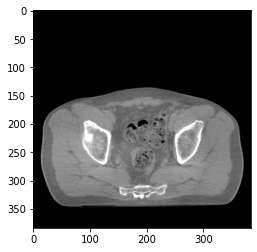

In [29]:
plt.imshow(x.squeeze(), 'gray'),

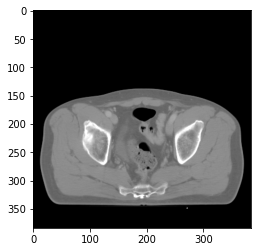

In [30]:
plt.imshow(y.squeeze(), 'gray')

In [31]:
x.shape, y.shape

((1, 384, 384), (1, 384, 384))

# training

In [32]:
import wandb

wandb.init(project="cbct_gan", config={
    "data": {
        "batchsize": BATCH,
    },
    "epochs": EPOCH,
    "model": {
        "in_channels": GEN_IN_CHANNELS,
        "out_channels": GEN_N_CLASSES,
        "optimizer": GEN_OPTIM_NAME,
        "init_lr": GEN_init_lr,
        "momentum": GEN_momentum,
        "encoder": ENCODER,
        "encoder_weight": ENCODER_WEIGHT,
        "activation": GEN_ACT,
        "decoder_attention_type": DECODER_ATT
    },
    "discriminator": {
        "in_channels": DIS_IN_CHANNELS,
        "out_channels": DIS_N_CLASSES,
        "optimizer": DIS_OPTIM_NAME,
        "init_lr": DIS_init_lr,
        "momentum": DIS_momentum,
        "encoder": "resnet34"
    }
})

wandb: Currently logged in as: junjun (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [33]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=4)

In [34]:
import segmentation_models_pytorch as smp
import torchvision.models as models

model = smp.Unet(encoder_name=ENCODER, 
                  encoder_weights=ENCODER_WEIGHT, 
                  in_channels=GEN_IN_CHANNELS, 
                  classes=GEN_N_CLASSES,
                 decoder_attention_type=DECODER_ATT)

replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)

In [35]:
tf_discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)
replace_relu_to_leakyReLU(tf_discriminator)
replace_bn_to_instanceNorm(tf_discriminator)

In [36]:
edge_discriminator = Discriminator(in_channel=E_IN_CHANNELS, n_classes=E_N_CLASSES, activation=E_ACT)
replace_relu_to_leakyReLU(edge_discriminator)
replace_bn_to_instanceNorm(edge_discriminator)

In [37]:
from codes.optimizer import Optimizer
# optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum)
gen_optimizer = Optimizer(model.parameters(), name=GEN_OPTIM_NAME, lr=GEN_init_lr)
tf_dis_optimizer = Optimizer(tf_discriminator.parameters(), name=DIS_OPTIM_NAME, lr=DIS_init_lr)
edge_dis_optimizer = Optimizer(edge_discriminator.parameters(), name=E_OPTIM_NAME, lr=E_init_lr)

In [38]:
from codes.scheduler import Scheduler
tf_scheduler = Scheduler(tf_dis_optimizer, name=DIS_scheduler, T_0=10, T_mult=5)
edge_scheduler = Scheduler(edge_dis_optimizer, name=E_scheduler, T_0=10, T_mult=5)

In [39]:
wandb.watch(model)
wandb.watch(tf_discriminator)
wandb.watch(edge_discriminator)

max_score = 0

for epoch in range(EPOCH):
        
        loss_air, loss_bone, loss_edge_gen, loss_tf_gen, loss_edge_dis, loss_tf_dis = train_a2b_epoch(model, gen_optimizer, 
                                                                                             tf_discriminator, tf_dis_optimizer, tf_scheduler, 
                                                                                             edge_discriminator, edge_dis_optimizer, edge_scheduler,
                                                                                             trainloader, device)
        
        score_ssim_train, score_psnr_train, score_snr_train, score_mae_train, \
            score_air_train, score_bone_train, score_cont_train, score_tf_acc_train, score_edge_acc_train = eval_epoch(model, tf_discriminator, edge_discriminator, trainloader, device)
        
        score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, \
            score_air_test, score_bone_test, score_cont_test, score_tf_acc_test, score_edge_acc_test = eval_epoch(model, tf_discriminator, edge_discriminator, testloader, device)

        wandb.log({
            "loss mask": loss_air,
            "loss bone": loss_bone,
            "loss gen": loss_tf_gen,
            "loss dis": loss_tf_dis,
            "loss edge gen": loss_edge_gen,
            "loss edge dis": loss_edge_dis,
            
            "trainset cont score": score_cont_train,
            "trainset ssim score": score_ssim_train,
            "trainset psnr score": score_psnr_train,
            "trainset mae error": score_mae_train,
            "trainset snr score": score_snr_train,
            "trainset mask score": score_air_train,
            "trainset bone score": score_bone_train,
            "trainset acc score": score_tf_acc_train,
            "trainset edge acc score": score_edge_acc_train,
            
            "testset cont score": score_cont_test,
            "testset mae error": score_mae_test,
            "testset ssim score": score_ssim_test,
            "testset psnr score": score_psnr_test,
            "testset snr score": score_snr_test,
            "testset mask score": score_air_test,
            "testset bone score": score_bone_test,
            "testset acc score": score_tf_acc_test,
            "testset edge acc score": score_edge_acc_test
        })
        
        
        if score_air_test +  score_bone_test + score_cont_test >= max_score:
            max_score = score_air_test +  score_bone_test + score_cont_test
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": gen_optimizer.state_dict(),
                "tf_discriminator": tf_discriminator.state_dict(),
                "tf_dis_optimizer": tf_dis_optimizer.state_dict(),
                "tf_scheduler": tf_scheduler.state_dict(),
                "edge_discriminator": edge_discriminator.state_dict(),
                "edge_dis_optimizer": edge_dis_optimizer.state_dict(),
                "edge_scheduler": edge_scheduler.state_dict()
            }
            torch.save(checkpoint, os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

84it [00:42,  1.98it/s]
84it [01:27,  1.04s/it]
84it [00:29,  2.83it/s]
12it [00:04,  2.58it/s]
84it [00:40,  2.08it/s]
84it [01:28,  1.05s/it]
84it [00:29,  2.85it/s]
12it [00:04,  2.55it/s]
84it [00:40,  2.07it/s]
84it [01:28,  1.05s/it]
84it [00:29,  2.83it/s]
12it [00:04,  2.55it/s]
84it [00:40,  2.07it/s]
84it [01:28,  1.06s/it]
84it [00:29,  2.84it/s]
12it [00:04,  2.56it/s]
84it [00:40,  2.08it/s]
84it [01:28,  1.06s/it]
84it [00:29,  2.82it/s]
12it [00:04,  2.57it/s]
84it [00:40,  2.07it/s]
84it [01:28,  1.06s/it]
84it [00:29,  2.84it/s]
12it [00:04,  2.54it/s]
84it [00:40,  2.07it/s]
84it [01:28,  1.06s/it]
84it [00:29,  2.85it/s]
12it [00:04,  2.55it/s]
84it [00:40,  2.07it/s]
84it [01:28,  1.06s/it]
84it [00:29,  2.82it/s]
12it [00:04,  2.56it/s]
84it [00:40,  2.08it/s]
84it [01:29,  1.06s/it]
84it [00:29,  2.84it/s]
12it [00:04,  2.58it/s]
84it [00:40,  2.07it/s]
84it [01:28,  1.06s/it]
84it [00:29,  2.85it/s]
12it [00:04,  2.58it/s]
84it [00:40,  2.07it/s]
84it [01:28,  1.

In [40]:
checkpoint = torch.load(os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

In [41]:
model = smp.Unet(encoder_name=ENCODER, 
                  encoder_weights=ENCODER_WEIGHT, 
                  in_channels=GEN_IN_CHANNELS, 
                  classes=GEN_N_CLASSES,
                 decoder_attention_type=DECODER_ATT)
replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [42]:
os.mkdir(os.path.join("eval-gan", wandb.run.name))

0it [00:00, ?it/s]

ssim score = 0.8815827369689941
psnr score = 25.704755783081055
snr score = 15.767696380615234
mae error = 0.019457224756479263
air dice score = 0.99691871511405
bone dice score = 0.9567144334472343
contour dice score = 0.48148149251937866


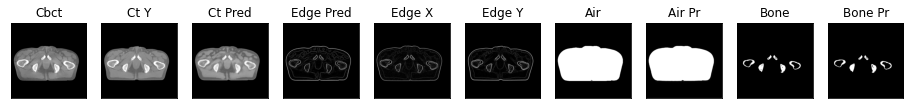

1it [00:00,  2.02it/s]

ssim score = 0.8832939267158508
psnr score = 25.55860710144043
snr score = 15.669078826904297
mae error = 0.019714798778295517
air dice score = 0.9964594807238429
bone dice score = 0.9512267218452376
contour dice score = 0.5161676406860352


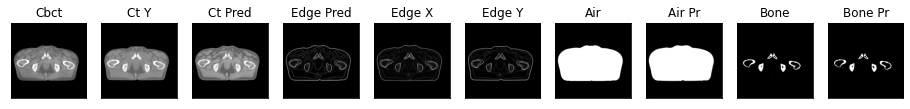

2it [00:00,  2.18it/s]

ssim score = 0.8808087706565857
psnr score = 25.21662712097168
snr score = 15.489996910095215
mae error = 0.021067658439278603
air dice score = 0.9965269237202289
bone dice score = 0.9329446064148441
contour dice score = 0.4760191738605499


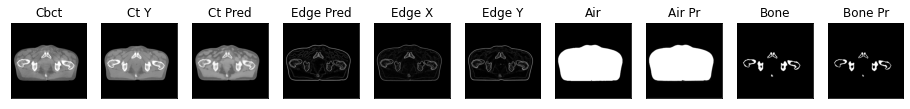

3it [00:01,  1.97it/s]

ssim score = 0.8774975538253784
psnr score = 25.10912322998047
snr score = 15.471746444702148
mae error = 0.021857652813196182
air dice score = 0.9969038416029059
bone dice score = 0.9035354717875961
contour dice score = 0.4915865361690521


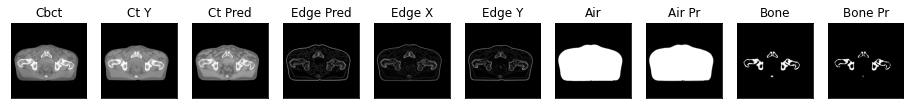

4it [00:01,  2.14it/s]

ssim score = 0.8775490522384644
psnr score = 25.118940353393555
snr score = 15.521864891052246
mae error = 0.02192091755568981
air dice score = 0.9977550313998934
bone dice score = 0.8760384075965472
contour dice score = 0.4503311216831207


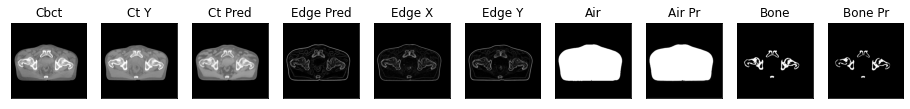

5it [00:02,  2.26it/s]

ssim score = 0.8749191164970398
psnr score = 24.78986358642578
snr score = 15.32931900024414
mae error = 0.023641549050807953
air dice score = 0.9978934817170132
bone dice score = 0.834693490227418
contour dice score = 0.43236714601516724


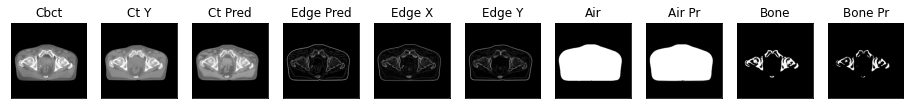

6it [00:02,  2.38it/s]

ssim score = 0.8727139234542847
psnr score = 24.523151397705078
snr score = 15.038555145263672
mae error = 0.023810600861907005
air dice score = 0.9974892718888503
bone dice score = 0.8455855855869767
contour dice score = 0.43462470173835754


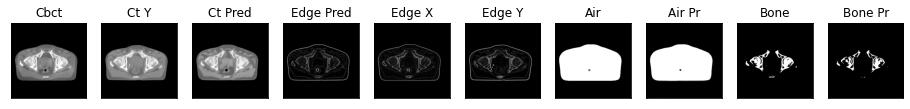

7it [00:02,  2.47it/s]

ssim score = 0.8695923089981079
psnr score = 25.101335525512695
snr score = 15.431201934814453
mae error = 0.021905649453401566
air dice score = 0.9975156653892987
bone dice score = 0.89564471552563
contour dice score = 0.41237112879753113


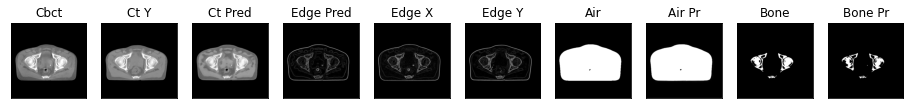

8it [00:03,  2.53it/s]

ssim score = 0.8712031841278076
psnr score = 25.494029998779297
snr score = 15.729340553283691
mae error = 0.0209956057369709
air dice score = 0.9972070996336876
bone dice score = 0.9200121963622319
contour dice score = 0.44999998807907104


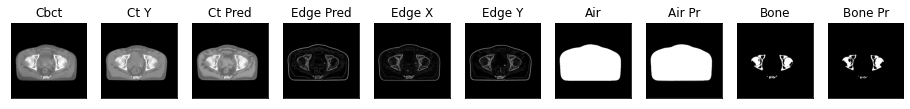

9it [00:03,  2.57it/s]

ssim score = 0.8728481531143188
psnr score = 25.365903854370117
snr score = 15.585929870605469
mae error = 0.02101859636604786
air dice score = 0.9967600611309254
bone dice score = 0.9197792869278462
contour dice score = 0.40684178471565247


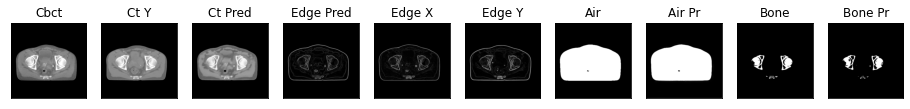

10it [00:04,  2.60it/s]

ssim score = 0.8794891834259033
psnr score = 25.56656265258789
snr score = 15.81885814666748
mae error = 0.020637691020965576
air dice score = 0.9971312063277421
bone dice score = 0.93529674252638
contour dice score = 0.3865443468093872


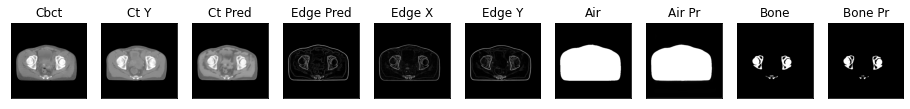

11it [00:04,  2.62it/s]

ssim score = 0.8766999244689941
psnr score = 24.576528549194336
snr score = 14.852535247802734
mae error = 0.022347114980220795
air dice score = 0.9967259992954716
bone dice score = 0.931325165786992
contour dice score = 0.4156959056854248


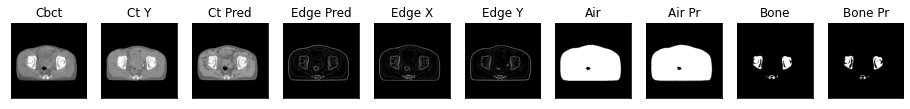

12it [00:04,  2.64it/s]

ssim score = 0.8806285858154297
psnr score = 23.986635208129883
snr score = 14.230719566345215
mae error = 0.023296676576137543
air dice score = 0.9965632858340354
bone dice score = 0.9394736842112502
contour dice score = 0.44049081206321716


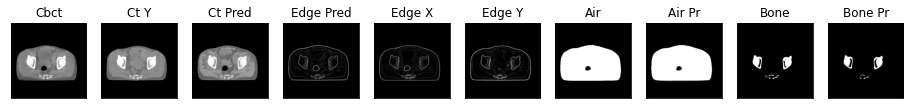

13it [00:05,  2.28it/s]

ssim score = 0.8792222142219543
psnr score = 24.024211883544922
snr score = 14.12633991241455
mae error = 0.02206357941031456
air dice score = 0.9966213362615122
bone dice score = 0.9242819843351922
contour dice score = 0.44375771284103394


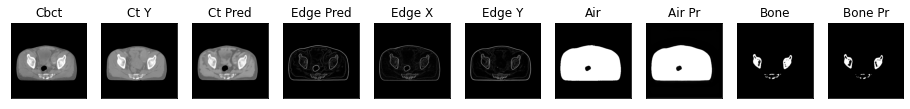

14it [00:05,  2.40it/s]

ssim score = 0.8744024038314819
psnr score = 23.96399688720703
snr score = 13.980464935302734
mae error = 0.022034062072634697
air dice score = 0.9973572209427002
bone dice score = 0.92390405293736
contour dice score = 0.38689741492271423


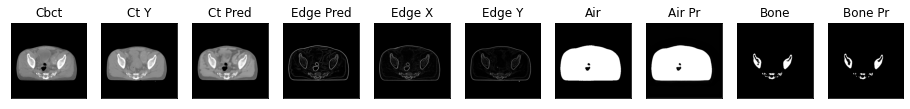

15it [00:06,  2.47it/s]

ssim score = 0.8661959171295166
psnr score = 23.63782501220703
snr score = 13.677774429321289
mae error = 0.023425836116075516
air dice score = 0.9979927825585638
bone dice score = 0.9199680935931938
contour dice score = 0.42884013056755066


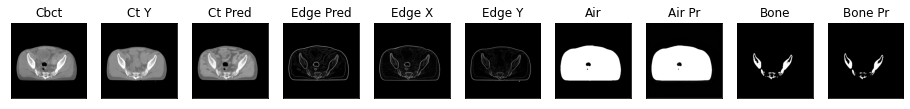

16it [00:06,  2.54it/s]

ssim score = 0.865009069442749
psnr score = 23.02886199951172
snr score = 13.06627082824707
mae error = 0.025100963190197945
air dice score = 0.9976883358178347
bone dice score = 0.9128010139428036
contour dice score = 0.40402770042419434


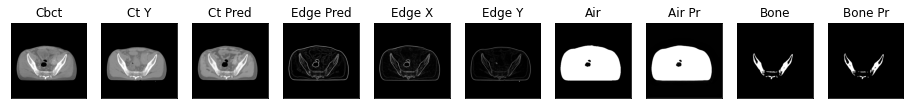

17it [00:06,  2.58it/s]

ssim score = 0.8582577109336853
psnr score = 22.64178466796875
snr score = 12.577433586120605
mae error = 0.025789299979805946
air dice score = 0.9965406986261046
bone dice score = 0.8989664082700392
contour dice score = 0.4049689471721649


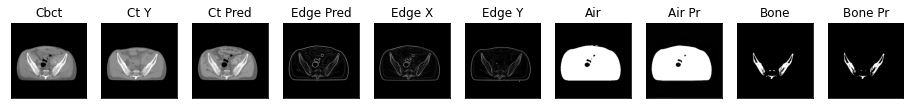

18it [00:07,  2.62it/s]

ssim score = 0.8565285801887512
psnr score = 22.461795806884766
snr score = 12.346761703491211
mae error = 0.026226036250591278
air dice score = 0.9956828842288009
bone dice score = 0.8848140495882643
contour dice score = 0.4227330684661865


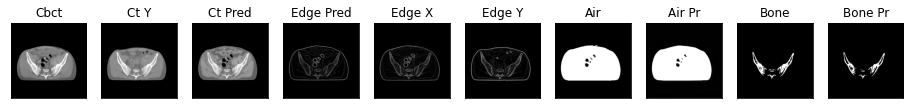

19it [00:07,  2.65it/s]

ssim score = 0.8590243458747864
psnr score = 22.523784637451172
snr score = 12.396441459655762
mae error = 0.026424581184983253
air dice score = 0.9964933240411991
bone dice score = 0.8900704506195657
contour dice score = 0.38451775908470154


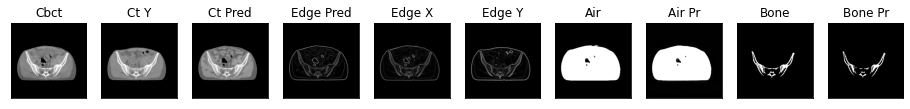

20it [00:08,  2.65it/s]

ssim score = 0.8544836640357971
psnr score = 22.49462127685547
snr score = 12.30242919921875
mae error = 0.02629186026751995
air dice score = 0.9958895541059826
bone dice score = 0.8802786242942928
contour dice score = 0.37973058223724365


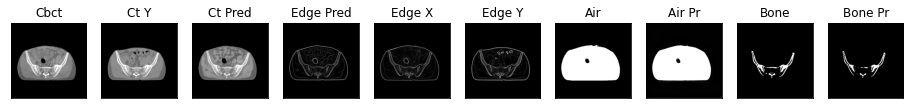

21it [00:08,  2.67it/s]

ssim score = 0.8535884618759155
psnr score = 22.60016441345215
snr score = 12.348542213439941
mae error = 0.026032615453004837
air dice score = 0.9942812113024944
bone dice score = 0.8954590465427152
contour dice score = 0.3527131676673889


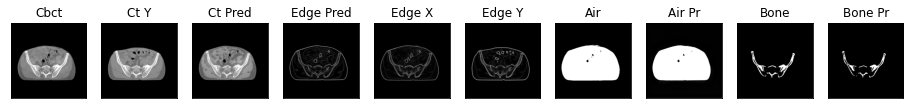

22it [00:08,  2.68it/s]

ssim score = 0.8608648180961609
psnr score = 22.809284210205078
snr score = 12.5242338180542
mae error = 0.025539090856909752
air dice score = 0.9946621444749273
bone dice score = 0.8898972374230629
contour dice score = 0.34415584802627563


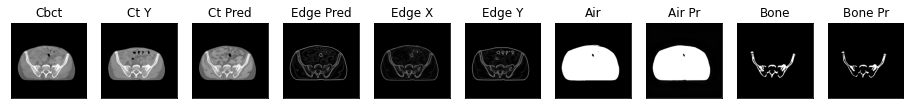

23it [00:09,  2.31it/s]

ssim score = 0.8592931032180786
psnr score = 22.828689575195312
snr score = 12.495077133178711
mae error = 0.025494439527392387
air dice score = 0.9943910624798924
bone dice score = 0.8828175579453216
contour dice score = 0.3448275923728943


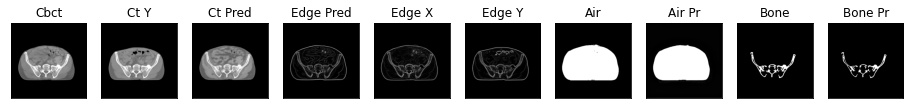

24it [00:09,  2.41it/s]

ssim score = 0.8562396764755249
psnr score = 22.556957244873047
snr score = 12.126346588134766
mae error = 0.02595125138759613
air dice score = 0.9942040140409868
bone dice score = 0.8868811881202119
contour dice score = 0.3707185983657837


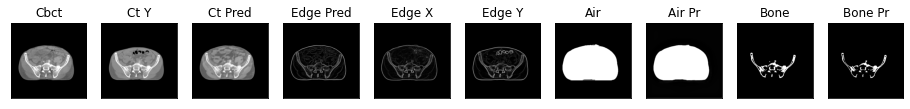

25it [00:10,  2.48it/s]

ssim score = 0.8612263202667236
psnr score = 22.692337036132812
snr score = 12.17898941040039
mae error = 0.025510499253869057
air dice score = 0.9946349372883845
bone dice score = 0.8836011284204146
contour dice score = 0.3335602581501007


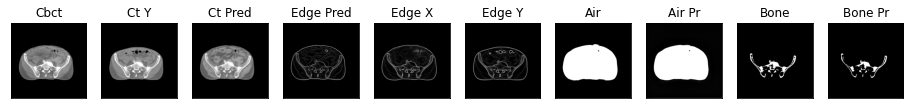

26it [00:10,  2.55it/s]

ssim score = 0.8568353652954102
psnr score = 22.759899139404297
snr score = 12.155366897583008
mae error = 0.025365140289068222
air dice score = 0.995207745451013
bone dice score = 0.8809005083529302
contour dice score = 0.4156206548213959


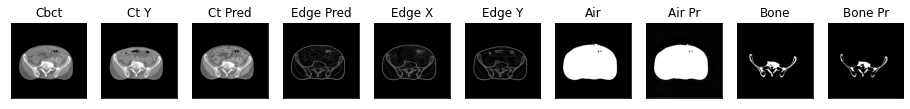

27it [00:10,  2.59it/s]

ssim score = 0.8574544787406921
psnr score = 22.57981300354004
snr score = 11.934170722961426
mae error = 0.025718508288264275
air dice score = 0.9943705093701459
bone dice score = 0.8903624099703856
contour dice score = 0.39745402336120605


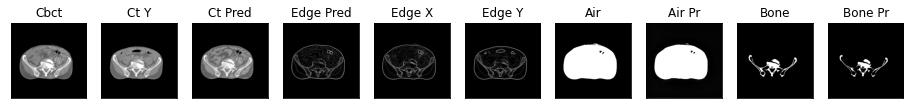

28it [00:11,  2.63it/s]

ssim score = 0.8404481410980225
psnr score = 23.239479064941406
snr score = 14.6116361618042
mae error = 0.029483385384082794
air dice score = 0.9967301309181565
bone dice score = 0.9728000000008704
contour dice score = 0.5662139058113098


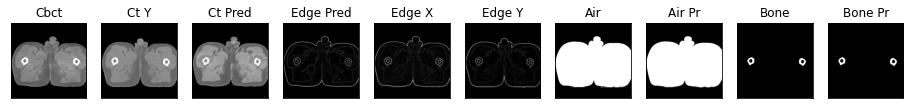

29it [00:11,  2.65it/s]

ssim score = 0.8457058668136597
psnr score = 23.770238876342773
snr score = 15.18165397644043
mae error = 0.02864445187151432
air dice score = 0.9962353171256425
bone dice score = 0.9682824655904164
contour dice score = 0.5450716018676758


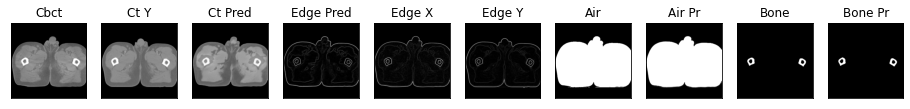

30it [00:11,  2.66it/s]

ssim score = 0.8509020209312439
psnr score = 24.492910385131836
snr score = 15.991774559020996
mae error = 0.02657388709485531
air dice score = 0.996667496251694
bone dice score = 0.9628217349865867
contour dice score = 0.5170731544494629


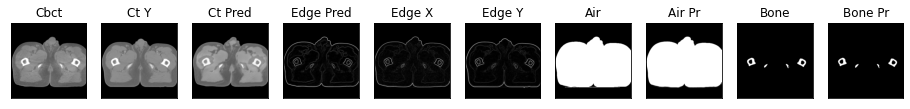

31it [00:12,  2.66it/s]

ssim score = 0.8565889596939087
psnr score = 25.08423614501953
snr score = 16.745655059814453
mae error = 0.024805288761854172
air dice score = 0.9977669680253975
bone dice score = 0.9622487334537956
contour dice score = 0.5190279483795166


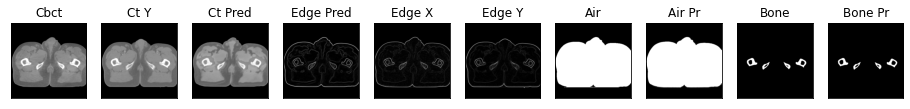

32it [00:12,  2.67it/s]

ssim score = 0.8596424460411072
psnr score = 25.414836883544922
snr score = 17.20440101623535
mae error = 0.02384995110332966
air dice score = 0.9983175099146747
bone dice score = 0.9499284692424903
contour dice score = 0.45682451128959656


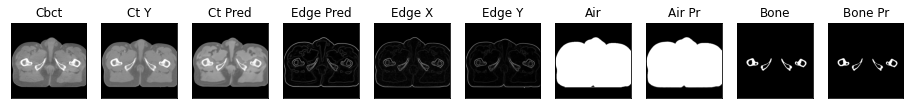

33it [00:13,  2.30it/s]

ssim score = 0.8582751154899597
psnr score = 25.623014450073242
snr score = 17.51581382751465
mae error = 0.024033332243561745
air dice score = 0.9982703414429792
bone dice score = 0.9306527548042925
contour dice score = 0.4816364347934723


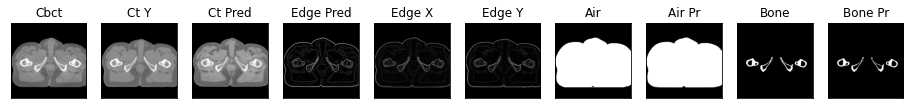

34it [00:13,  2.40it/s]

ssim score = 0.8615521788597107
psnr score = 26.010169982910156
snr score = 17.970073699951172
mae error = 0.023771846666932106
air dice score = 0.9983187265247729
bone dice score = 0.9150450878035707
contour dice score = 0.45239201188087463


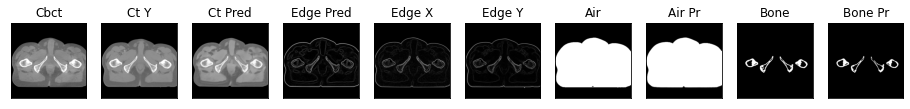

35it [00:14,  2.47it/s]

ssim score = 0.8580854535102844
psnr score = 26.038637161254883
snr score = 17.9886474609375
mae error = 0.024082012474536896
air dice score = 0.99826388888889
bone dice score = 0.9283737407292331
contour dice score = 0.4562702476978302


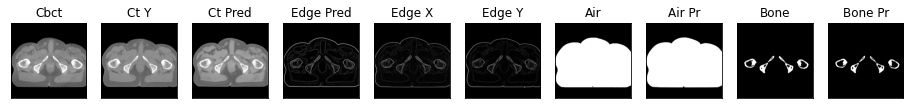

36it [00:14,  2.53it/s]

ssim score = 0.859764575958252
psnr score = 26.276641845703125
snr score = 18.212987899780273
mae error = 0.02342996932566166
air dice score = 0.998403949187439
bone dice score = 0.9377313302858945
contour dice score = 0.43981480598449707


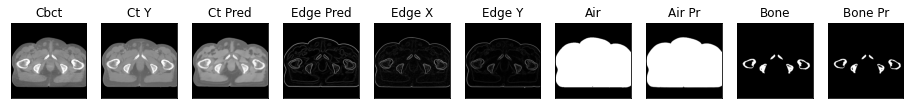

37it [00:14,  2.57it/s]

ssim score = 0.8651653528213501
psnr score = 26.449060440063477
snr score = 18.397411346435547
mae error = 0.023511061444878578
air dice score = 0.9984296203236769
bone dice score = 0.918262494162561
contour dice score = 0.44485634565353394


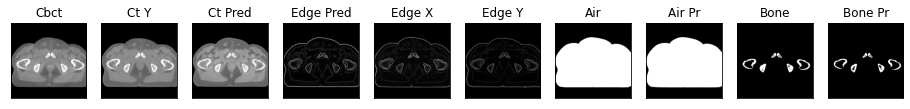

38it [00:15,  2.61it/s]

ssim score = 0.8661757707595825
psnr score = 26.35652732849121
snr score = 18.343963623046875
mae error = 0.023995384573936462
air dice score = 0.9983708048224187
bone dice score = 0.9207529073262107
contour dice score = 0.43441861867904663


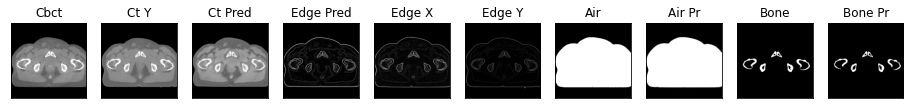

39it [00:15,  2.63it/s]

ssim score = 0.8636240363121033
psnr score = 25.996803283691406
snr score = 18.125530242919922
mae error = 0.02569904364645481
air dice score = 0.9984301784857452
bone dice score = 0.8977629103084073
contour dice score = 0.4416433274745941


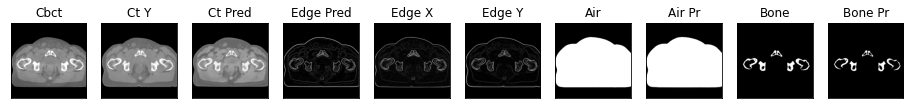

40it [00:15,  2.65it/s]

ssim score = 0.8628603219985962
psnr score = 25.65912437438965
snr score = 17.88253402709961
mae error = 0.027851814404129982
air dice score = 0.9986294624051459
bone dice score = 0.8706674940176343
contour dice score = 0.3800186812877655


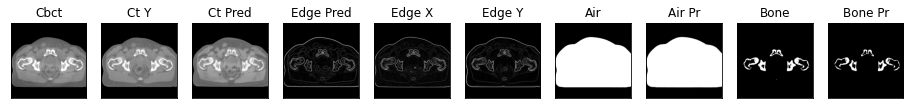

41it [00:16,  2.65it/s]

ssim score = 0.8550445437431335
psnr score = 25.007179260253906
snr score = 17.196542739868164
mae error = 0.02856111153960228
air dice score = 0.9983328371539159
bone dice score = 0.8188100152578407
contour dice score = 0.40449437499046326


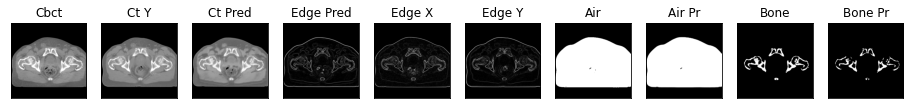

42it [00:16,  2.66it/s]

ssim score = 0.8516141772270203
psnr score = 24.067546844482422
snr score = 16.329097747802734
mae error = 0.03072265163064003
air dice score = 0.9979152438805231
bone dice score = 0.7619807032950963
contour dice score = 0.37799718976020813


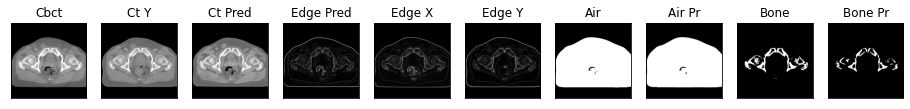

43it [00:17,  2.25it/s]

ssim score = 0.850415825843811
psnr score = 24.369213104248047
snr score = 16.494667053222656
mae error = 0.02890993468463421
air dice score = 0.9981846815979621
bone dice score = 0.799520047997205
contour dice score = 0.39472445845603943


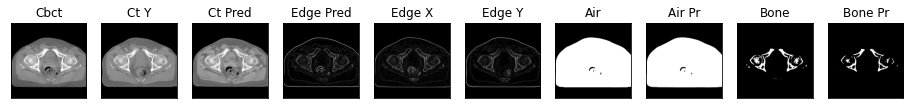

44it [00:17,  2.35it/s]

ssim score = 0.8543011546134949
psnr score = 24.902963638305664
snr score = 16.849855422973633
mae error = 0.02632410265505314
air dice score = 0.9984150038268929
bone dice score = 0.8385766977669931
contour dice score = 0.44328922033309937


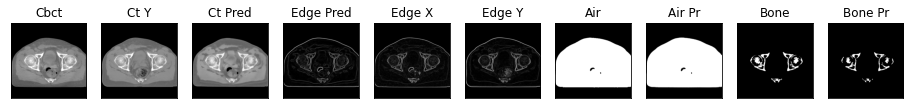

45it [00:17,  2.44it/s]

ssim score = 0.8485252857208252
psnr score = 25.072181701660156
snr score = 16.92848777770996
mae error = 0.026579448953270912
air dice score = 0.9983823848958218
bone dice score = 0.8435938071456345
contour dice score = 0.4483412206172943


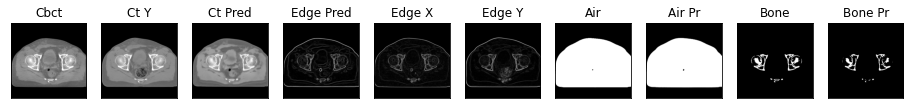

46it [00:18,  2.51it/s]

ssim score = 0.8525090217590332
psnr score = 25.185924530029297
snr score = 17.057918548583984
mae error = 0.025992855429649353
air dice score = 0.9985695062371961
bone dice score = 0.8590060715104676
contour dice score = 0.48384031653404236


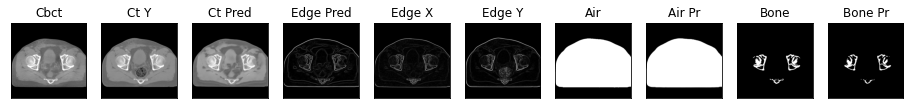

47it [00:18,  2.56it/s]

ssim score = 0.8416818380355835
psnr score = 24.8544864654541
snr score = 16.736515045166016
mae error = 0.02702670358121395
air dice score = 0.9985313743532876
bone dice score = 0.8557682464954881
contour dice score = 0.46000000834465027


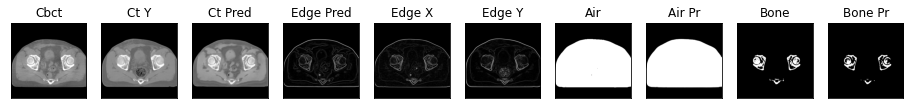

48it [00:19,  2.60it/s]

ssim score = 0.8449491262435913
psnr score = 24.908039093017578
snr score = 16.851659774780273
mae error = 0.026997148990631104
air dice score = 0.9985077365298768
bone dice score = 0.8659528058708512
contour dice score = 0.46666666865348816


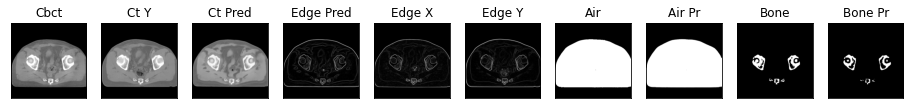

49it [00:19,  2.63it/s]

ssim score = 0.8468112349510193
psnr score = 25.306472778320312
snr score = 17.320175170898438
mae error = 0.026764795184135437
air dice score = 0.9982466680562548
bone dice score = 0.9094477151676531
contour dice score = 0.4515209197998047


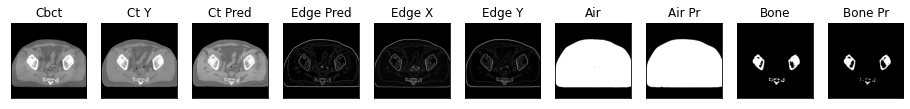

50it [00:19,  2.65it/s]

ssim score = 0.8554980754852295
psnr score = 25.500402450561523
snr score = 17.39499855041504
mae error = 0.025676533579826355
air dice score = 0.9983331290599349
bone dice score = 0.8889591234735676
contour dice score = 0.43536120653152466


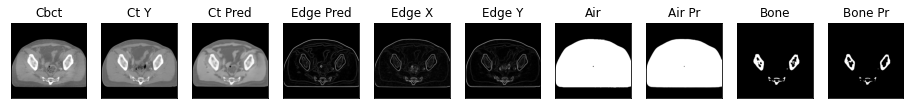

51it [00:20,  2.66it/s]

ssim score = 0.8501250147819519
psnr score = 24.607439041137695
snr score = 16.583662033081055
mae error = 0.02883949503302574
air dice score = 0.9982727150224803
bone dice score = 0.89023383769014
contour dice score = 0.4177820384502411


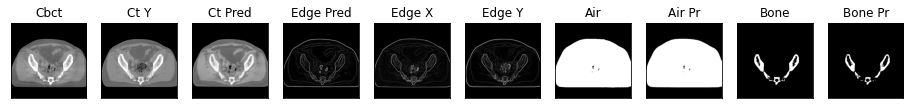

52it [00:20,  2.67it/s]

ssim score = 0.856081485748291
psnr score = 24.625263214111328
snr score = 16.6816349029541
mae error = 0.02933138981461525
air dice score = 0.9981173594132041
bone dice score = 0.858630482803261
contour dice score = 0.372783899307251


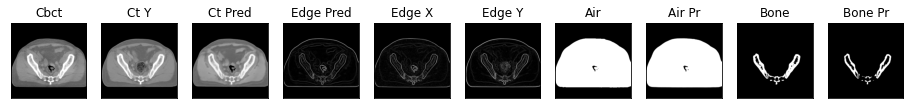

53it [00:21,  2.29it/s]

ssim score = 0.840440034866333
psnr score = 24.12494659423828
snr score = 16.20287322998047
mae error = 0.030573640018701553
air dice score = 0.9982678702122479
bone dice score = 0.8476471998094779
contour dice score = 0.33301252126693726


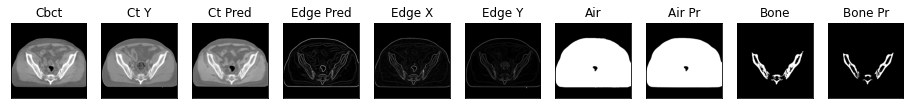

54it [00:21,  2.40it/s]

ssim score = 0.8402100205421448
psnr score = 24.70256805419922
snr score = 16.793033599853516
mae error = 0.02967660315334797
air dice score = 0.9983243907012768
bone dice score = 0.8592759091285279
contour dice score = 0.345158189535141


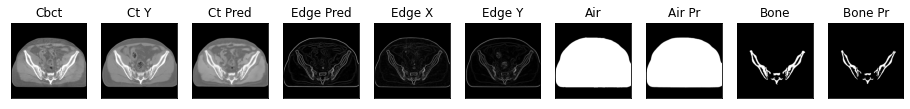

55it [00:21,  2.48it/s]

ssim score = 0.7912829518318176
psnr score = 20.97791862487793
snr score = 10.85812759399414
mae error = 0.03501414880156517
air dice score = 0.9968320259863136
bone dice score = 0.9420026007817425
contour dice score = 0.5622578859329224


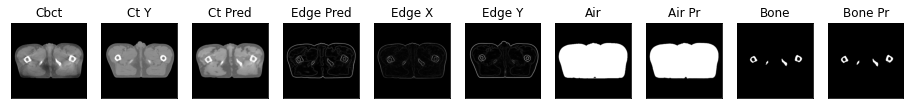

56it [00:22,  2.53it/s]

ssim score = 0.7810263633728027
psnr score = 20.723312377929688
snr score = 10.816499710083008
mae error = 0.03624352440237999
air dice score = 0.9966727887353964
bone dice score = 0.9321717486012825
contour dice score = 0.521212100982666


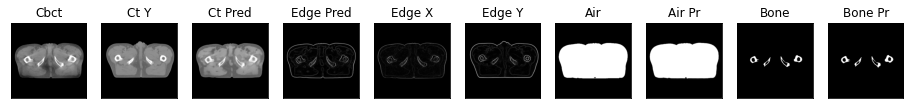

57it [00:22,  2.59it/s]

ssim score = 0.7788773775100708
psnr score = 20.75862693786621
snr score = 10.982953071594238
mae error = 0.0362243577837944
air dice score = 0.9969994351878027
bone dice score = 0.9083850931694801
contour dice score = 0.5329670310020447


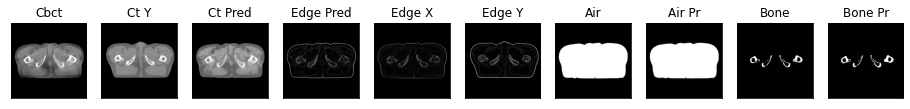

58it [00:23,  2.63it/s]

ssim score = 0.7818775177001953
psnr score = 21.018821716308594
snr score = 11.313551902770996
mae error = 0.03532250598073006
air dice score = 0.9967164755667182
bone dice score = 0.9061691909880648
contour dice score = 0.4756164252758026


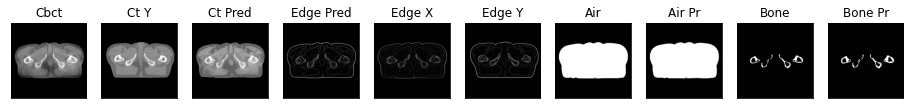

59it [00:23,  2.65it/s]

ssim score = 0.7807102203369141
psnr score = 21.08220863342285
snr score = 11.424503326416016
mae error = 0.034867171198129654
air dice score = 0.9962987916385974
bone dice score = 0.9094509450961394
contour dice score = 0.495362788438797


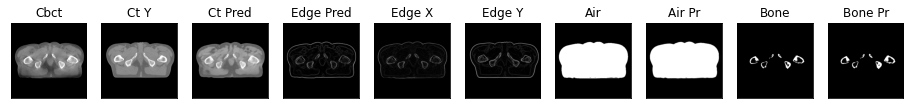

60it [00:23,  2.67it/s]

ssim score = 0.7781783938407898
psnr score = 21.235143661499023
snr score = 11.583056449890137
mae error = 0.03434359282255173
air dice score = 0.9959545232614948
bone dice score = 0.9234035025663647
contour dice score = 0.4755319058895111


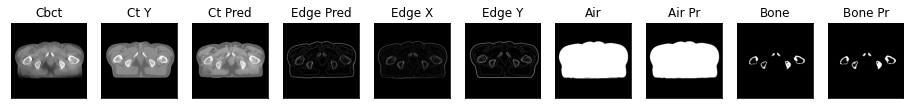

61it [00:24,  2.67it/s]

ssim score = 0.7787514925003052
psnr score = 21.24664306640625
snr score = 11.58804988861084
mae error = 0.03434332087635994
air dice score = 0.995403716994087
bone dice score = 0.9167719805033983
contour dice score = 0.5199787020683289


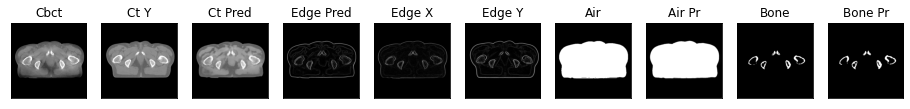

62it [00:24,  2.69it/s]

ssim score = 0.7791017293930054
psnr score = 21.12598419189453
snr score = 11.481504440307617
mae error = 0.03446121886372566
air dice score = 0.9961013982984803
bone dice score = 0.938409050099867
contour dice score = 0.4580233693122864


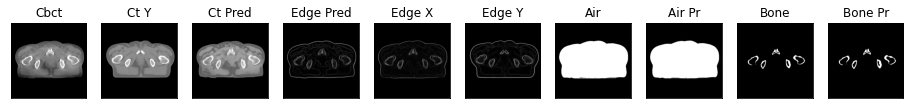

63it [00:25,  2.30it/s]

ssim score = 0.7767318487167358
psnr score = 20.999717712402344
snr score = 11.413244247436523
mae error = 0.035349998623132706
air dice score = 0.9960702847745209
bone dice score = 0.9297507283922022
contour dice score = 0.49626466631889343


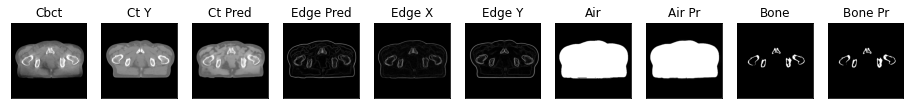

64it [00:25,  2.40it/s]

ssim score = 0.771369993686676
psnr score = 20.8510799407959
snr score = 11.363164901733398
mae error = 0.036630645394325256
air dice score = 0.9957010410731896
bone dice score = 0.9228182790780557
contour dice score = 0.49973586201667786


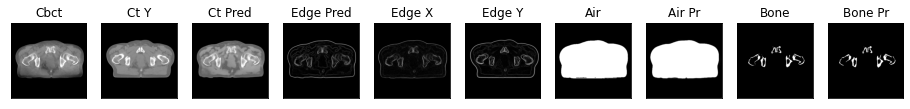

65it [00:25,  2.46it/s]

ssim score = 0.7663396596908569
psnr score = 20.68936538696289
snr score = 11.237279891967773
mae error = 0.03799374774098396
air dice score = 0.9959770857561304
bone dice score = 0.9137647586322857
contour dice score = 0.45508337020874023


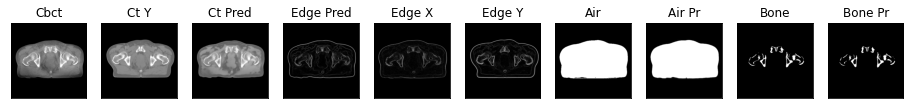

66it [00:26,  2.52it/s]

ssim score = 0.7552749514579773
psnr score = 20.580656051635742
snr score = 11.161277770996094
mae error = 0.038927264511585236
air dice score = 0.9963078670832182
bone dice score = 0.8870923540711552
contour dice score = 0.4863417148590088


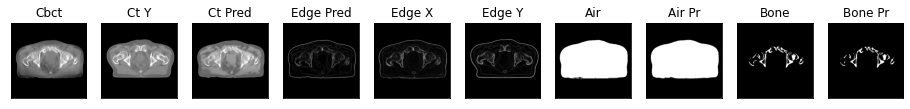

67it [00:26,  2.58it/s]

ssim score = 0.7543364763259888
psnr score = 20.592077255249023
snr score = 11.289515495300293
mae error = 0.03882107511162758
air dice score = 0.9965756371207849
bone dice score = 0.9106195834961762
contour dice score = 0.502639889717102


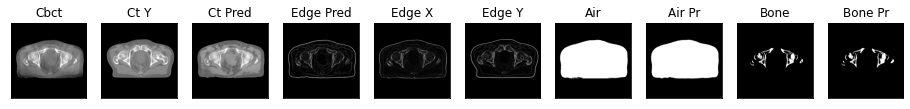

68it [00:26,  2.62it/s]

ssim score = 0.7570197582244873
psnr score = 20.664518356323242
snr score = 11.345970153808594
mae error = 0.03883478045463562
air dice score = 0.9971787858457646
bone dice score = 0.8983215425177095
contour dice score = 0.5029940009117126


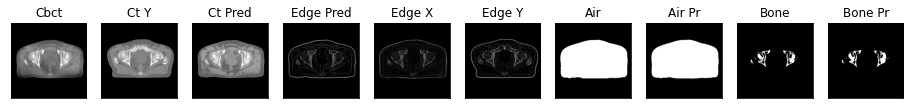

69it [00:27,  2.63it/s]

ssim score = 0.7739418148994446
psnr score = 21.211246490478516
snr score = 11.693535804748535
mae error = 0.03632044419646263
air dice score = 0.9970093843456765
bone dice score = 0.9086390878539886
contour dice score = 0.5252416729927063


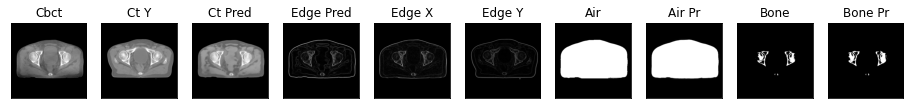

70it [00:27,  2.65it/s]

ssim score = 0.7895820140838623
psnr score = 21.88763427734375
snr score = 12.199530601501465
mae error = 0.03357197344303131
air dice score = 0.9970990610570428
bone dice score = 0.932548912300827
contour dice score = 0.4835756719112396


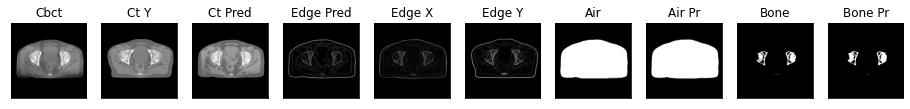

71it [00:28,  2.66it/s]

ssim score = 0.7941533327102661
psnr score = 22.28612518310547
snr score = 12.612188339233398
mae error = 0.031907401978969574
air dice score = 0.9966858209658248
bone dice score = 0.9517792676643659
contour dice score = 0.4970603883266449


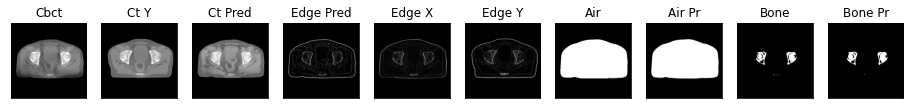

72it [00:28,  2.68it/s]

ssim score = 0.7999511957168579
psnr score = 22.470245361328125
snr score = 12.87813663482666
mae error = 0.03096691146492958
air dice score = 0.9971546000632335
bone dice score = 0.9645295141217437
contour dice score = 0.4690553843975067


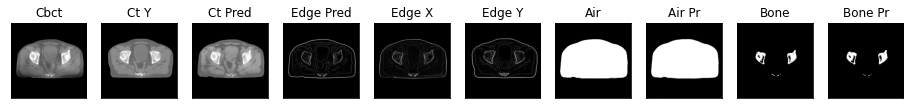

73it [00:29,  2.30it/s]

ssim score = 0.7935522794723511
psnr score = 22.36116600036621
snr score = 12.861231803894043
mae error = 0.031703248620033264
air dice score = 0.9973150129135117
bone dice score = 0.9442892841401692
contour dice score = 0.4658590257167816


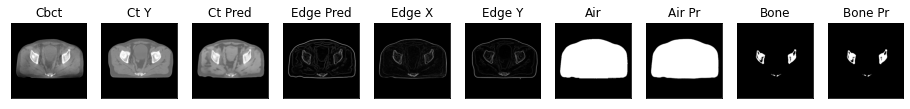

74it [00:29,  2.41it/s]

ssim score = 0.7941293120384216
psnr score = 22.655916213989258
snr score = 13.092555046081543
mae error = 0.030555523931980133
air dice score = 0.9968754245347126
bone dice score = 0.953231568691893
contour dice score = 0.5032188892364502


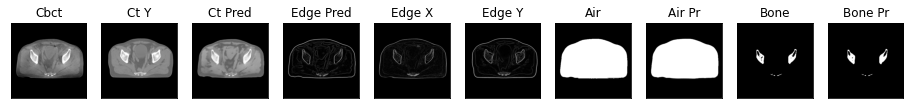

75it [00:29,  2.49it/s]

ssim score = 0.7969315648078918
psnr score = 22.779346466064453
snr score = 13.17959213256836
mae error = 0.029613783583045006
air dice score = 0.9965639820478697
bone dice score = 0.9521472392646425
contour dice score = 0.48801279067993164


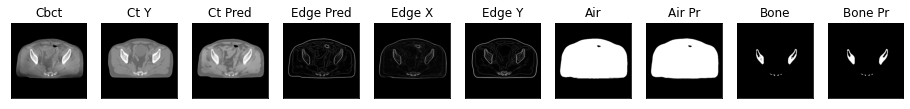

76it [00:30,  2.55it/s]

ssim score = 0.7979277968406677
psnr score = 22.589967727661133
snr score = 13.027957916259766
mae error = 0.030507035553455353
air dice score = 0.9965810660626296
bone dice score = 0.9412336085487901
contour dice score = 0.47770699858665466


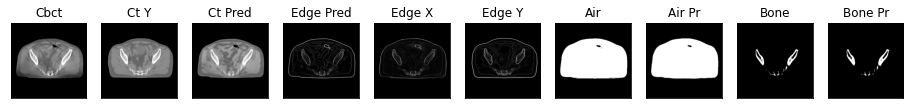

77it [00:30,  2.59it/s]

ssim score = 0.7990425229072571
psnr score = 22.49784278869629
snr score = 13.066335678100586
mae error = 0.0311601422727108
air dice score = 0.9966279632728321
bone dice score = 0.9436117059251448
contour dice score = 0.48850882053375244


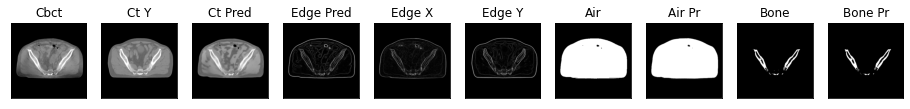

78it [00:30,  2.63it/s]

ssim score = 0.8039559125900269
psnr score = 22.446191787719727
snr score = 13.03243637084961
mae error = 0.030923238024115562
air dice score = 0.9965142540588942
bone dice score = 0.9226699859977802
contour dice score = 0.5018807053565979


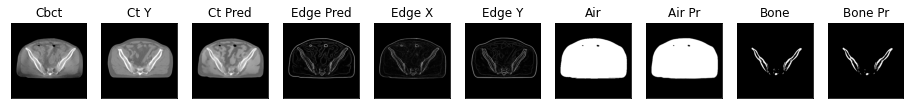

79it [00:31,  2.65it/s]

ssim score = 0.8026555180549622
psnr score = 22.774078369140625
snr score = 13.349054336547852
mae error = 0.030367540195584297
air dice score = 0.9959871657754045
bone dice score = 0.9216776149583682
contour dice score = 0.5067530870437622


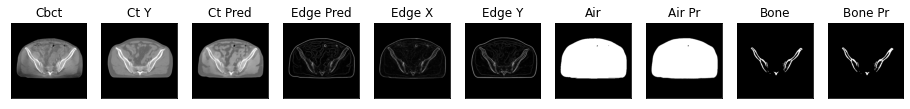

80it [00:31,  2.67it/s]

ssim score = 0.8052442073822021
psnr score = 22.878459930419922
snr score = 13.452693939208984
mae error = 0.030022459104657173
air dice score = 0.996333158721847
bone dice score = 0.914165859956209
contour dice score = 0.47577571868896484


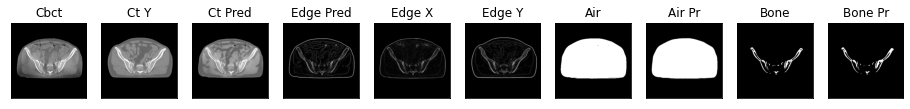

81it [00:31,  2.68it/s]

ssim score = 0.8516572713851929
psnr score = 23.586753845214844
snr score = 14.020889282226562
mae error = 0.02522784098982811
air dice score = 0.9957145696680615
bone dice score = 0.9355907250667799
contour dice score = 0.5596184134483337


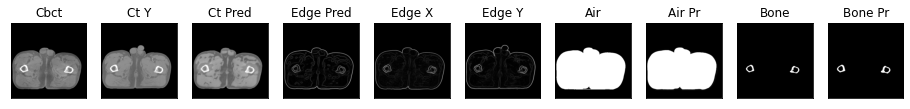

82it [00:32,  2.69it/s]

ssim score = 0.8541520237922668
psnr score = 23.884422302246094
snr score = 14.382948875427246
mae error = 0.024836523458361626
air dice score = 0.9960270759120775
bone dice score = 0.9150630391534484
contour dice score = 0.5178571343421936


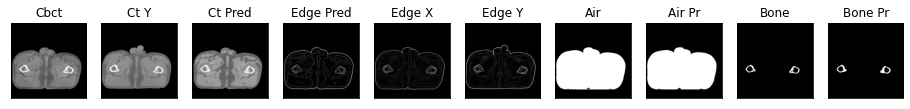

83it [00:32,  2.30it/s]

ssim score = 0.8619140982627869
psnr score = 25.356903076171875
snr score = 15.99464225769043
mae error = 0.02209218218922615
air dice score = 0.9967283261366945
bone dice score = 0.9313535614389638
contour dice score = 0.528723955154419


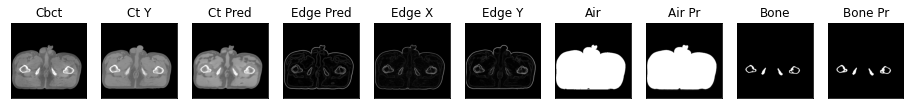

84it [00:33,  2.41it/s]

ssim score = 0.8596183657646179
psnr score = 25.341217041015625
snr score = 16.100448608398438
mae error = 0.022083403542637825
air dice score = 0.997374186230794
bone dice score = 0.9214507772037005
contour dice score = 0.5452674627304077


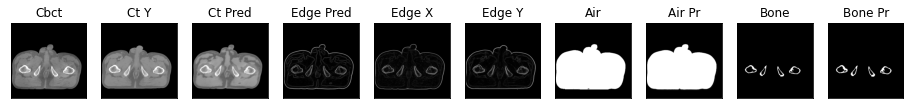

85it [00:33,  2.50it/s]

ssim score = 0.8557281494140625
psnr score = 25.172090530395508
snr score = 15.955493927001953
mae error = 0.022519957274198532
air dice score = 0.9974188247513798
bone dice score = 0.9216789268731788
contour dice score = 0.518941342830658


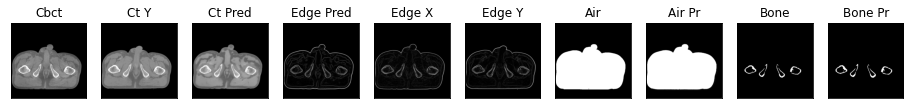

86it [00:34,  2.55it/s]

ssim score = 0.8545503616333008
psnr score = 25.086267471313477
snr score = 15.865274429321289
mae error = 0.022387979552149773
air dice score = 0.9972584917057778
bone dice score = 0.9159135559937934
contour dice score = 0.5128205418586731


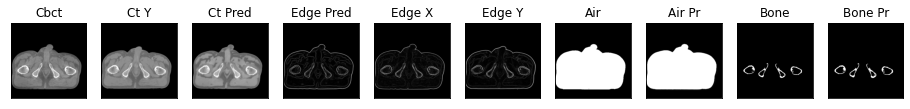

87it [00:34,  2.59it/s]

ssim score = 0.8546477556228638
psnr score = 24.759328842163086
snr score = 15.544590950012207
mae error = 0.022757483646273613
air dice score = 0.997104366676992
bone dice score = 0.9172758753382594
contour dice score = 0.4771413505077362


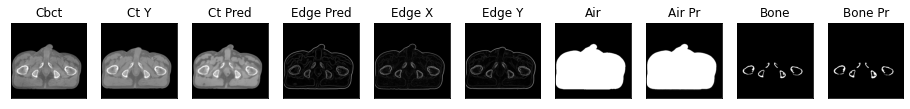

88it [00:34,  2.63it/s]

ssim score = 0.8557568192481995
psnr score = 24.559024810791016
snr score = 15.322729110717773
mae error = 0.022845817729830742
air dice score = 0.9973648721963035
bone dice score = 0.9166827759536694
contour dice score = 0.5134139657020569


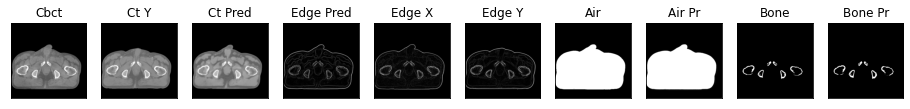

89it [00:35,  2.65it/s]

ssim score = 0.8575422763824463
psnr score = 24.585128784179688
snr score = 15.365744590759277
mae error = 0.022837230935692787
air dice score = 0.9974199965807203
bone dice score = 0.9367135455230068
contour dice score = 0.46691370010375977


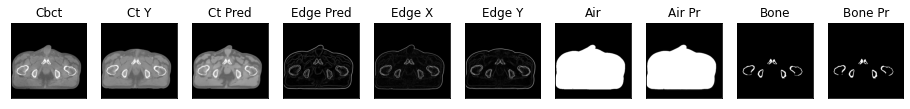

90it [00:35,  2.66it/s]

ssim score = 0.8601012229919434
psnr score = 24.862157821655273
snr score = 15.711366653442383
mae error = 0.022411832585930824
air dice score = 0.9977455867325067
bone dice score = 0.9310577897950142
contour dice score = 0.49466949701309204


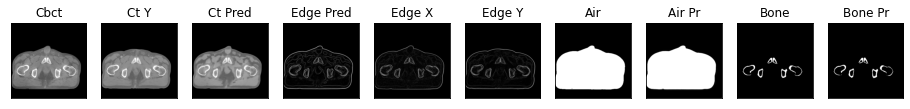

91it [00:35,  2.67it/s]

ssim score = 0.8594362735748291
psnr score = 25.08376121520996
snr score = 16.014328002929688
mae error = 0.022631226107478142
air dice score = 0.9977758285821707
bone dice score = 0.9302689180748863
contour dice score = 0.46484166383743286


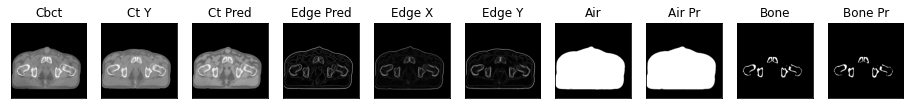

92it [00:36,  2.66it/s]

ssim score = 0.8619997501373291
psnr score = 25.31781768798828
snr score = 16.299087524414062
mae error = 0.022607561200857162
air dice score = 0.9982146649154142
bone dice score = 0.9123391370187383
contour dice score = 0.4728640615940094


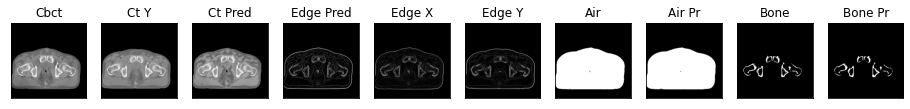

93it [00:36,  2.26it/s]

ssim score = 0.8627044558525085
psnr score = 25.483644485473633
snr score = 16.5811824798584
mae error = 0.023044787347316742
air dice score = 0.9983042157984002
bone dice score = 0.8656236291875183
contour dice score = 0.44217321276664734


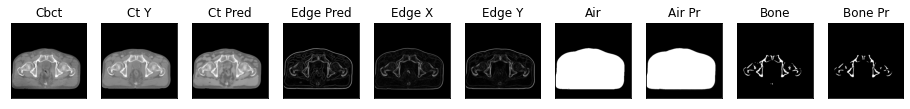

94it [00:37,  2.39it/s]

ssim score = 0.8615562915802002
psnr score = 25.013912200927734
snr score = 16.07321548461914
mae error = 0.023606697097420692
air dice score = 0.9984299919120808
bone dice score = 0.875019406926331
contour dice score = 0.47526881098747253


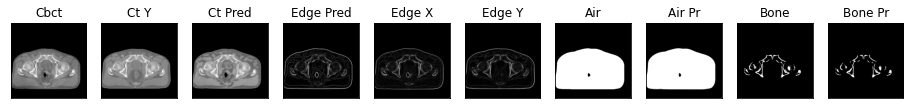

95it [00:37,  2.48it/s]

ssim score = 0.8538750410079956
psnr score = 24.296472549438477
snr score = 15.260106086730957
mae error = 0.024540046229958534
air dice score = 0.9979150523633418
bone dice score = 0.8960313024050303
contour dice score = 0.445523202419281


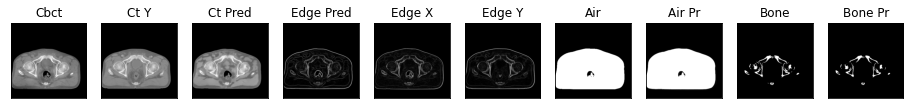

96it [00:37,  2.55it/s]

ssim score = 0.8591312766075134
psnr score = 24.219280242919922
snr score = 15.023154258728027
mae error = 0.023740511387586594
air dice score = 0.9973700930520614
bone dice score = 0.9029562982020733
contour dice score = 0.4610389471054077


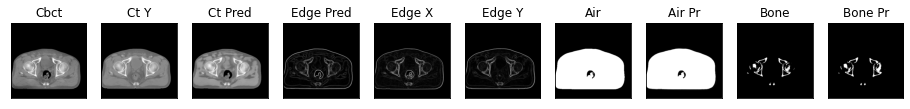

97it [00:38,  2.60it/s]

ssim score = 0.8571935296058655
psnr score = 23.934335708618164
snr score = 14.621787071228027
mae error = 0.02403203584253788
air dice score = 0.9970570062762211
bone dice score = 0.8924783814669199
contour dice score = 0.4573601186275482


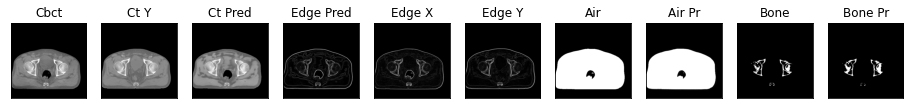

98it [00:38,  2.63it/s]

ssim score = 0.850209653377533
psnr score = 23.68952178955078
snr score = 14.33187484741211
mae error = 0.024917295202612877
air dice score = 0.9976347342145128
bone dice score = 0.9167443305387272
contour dice score = 0.4692433178424835


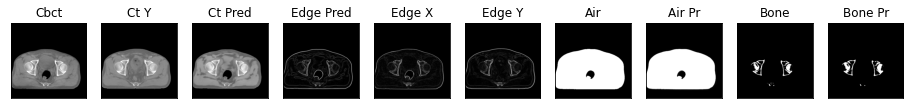

99it [00:39,  2.65it/s]

ssim score = 0.8447906970977783
psnr score = 23.14417266845703
snr score = 13.793201446533203
mae error = 0.02613079734146595
air dice score = 0.9975003892836382
bone dice score = 0.931198478124109
contour dice score = 0.46917620301246643


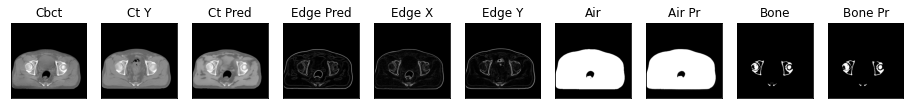

100it [00:39,  2.66it/s]

ssim score = 0.8464950323104858
psnr score = 22.95208168029785
snr score = 13.63121223449707
mae error = 0.02601362206041813
air dice score = 0.9976596565853998
bone dice score = 0.9457601222315392
contour dice score = 0.4614543318748474


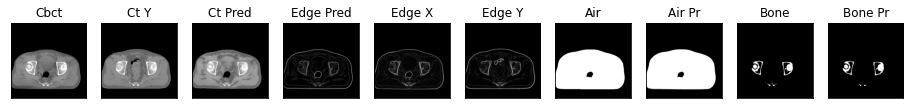

101it [00:39,  2.64it/s]

ssim score = 0.8508738279342651
psnr score = 23.497268676757812
snr score = 14.133814811706543
mae error = 0.024338295683264732
air dice score = 0.997564116233486
bone dice score = 0.9439972598057202
contour dice score = 0.44201311469078064


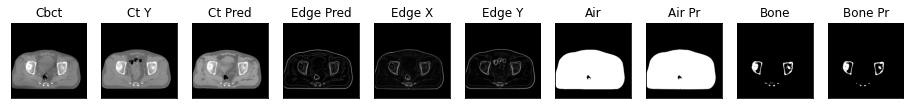

102it [00:40,  2.66it/s]

ssim score = 0.853705883026123
psnr score = 23.7601375579834
snr score = 14.306479454040527
mae error = 0.023537583649158478
air dice score = 0.997808896210875
bone dice score = 0.9390039171807685
contour dice score = 0.4310722053050995


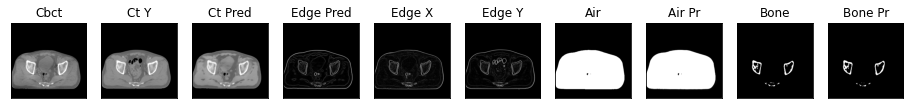

103it [00:40,  2.28it/s]

ssim score = 0.8552731871604919
psnr score = 23.48501968383789
snr score = 13.965633392333984
mae error = 0.023894036188721657
air dice score = 0.9974858474858496
bone dice score = 0.9466666666677124
contour dice score = 0.463481605052948


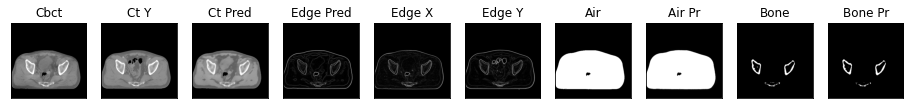

104it [00:41,  2.39it/s]

ssim score = 0.8536385297775269
psnr score = 23.72684097290039
snr score = 14.207152366638184
mae error = 0.023763218894600868
air dice score = 0.9971218312872906
bone dice score = 0.9472222222231385
contour dice score = 0.4191419184207916


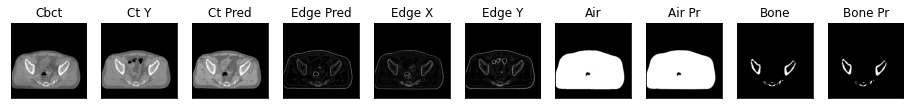

105it [00:41,  2.45it/s]

ssim score = 0.8476450443267822
psnr score = 23.539011001586914
snr score = 14.095489501953125
mae error = 0.024924473837018013
air dice score = 0.9968573437354435
bone dice score = 0.9289743960664115
contour dice score = 0.4108227491378784


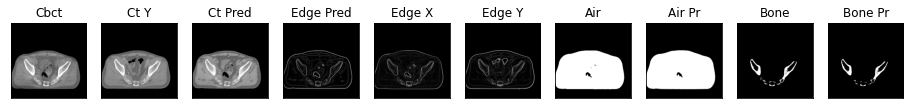

106it [00:41,  2.51it/s]

ssim score = 0.853632926940918
psnr score = 23.878456115722656
snr score = 14.470516204833984
mae error = 0.024034494534134865
air dice score = 0.9966300666308373
bone dice score = 0.929394226860965
contour dice score = 0.3843180537223816


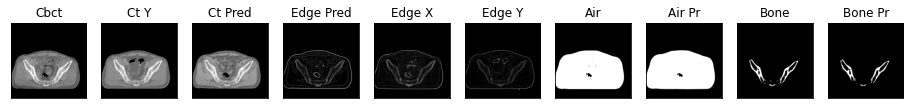

107it [00:42,  2.55it/s]

ssim score = 0.8558683395385742
psnr score = 24.576541900634766
snr score = 15.106905937194824
mae error = 0.02278735116124153
air dice score = 0.9966799070030827
bone dice score = 0.9150401836981193
contour dice score = 0.38602328300476074


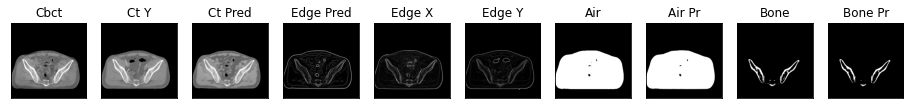

108it [00:42,  2.59it/s]

ssim score = 0.852711021900177
psnr score = 24.245004653930664
snr score = 14.714107513427734
mae error = 0.023518379777669907
air dice score = 0.9965482338895983
bone dice score = 0.9094197437843343
contour dice score = 0.3523489832878113


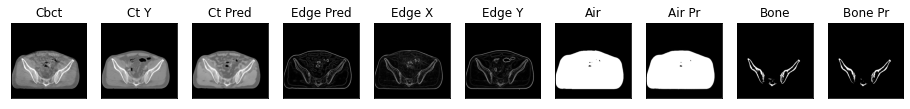

109it [00:43,  2.59it/s]

ssim score = 0.7714188098907471
psnr score = 21.95692253112793
snr score = 13.654231071472168
mae error = 0.03799838572740555
air dice score = 0.9978439746475058
bone dice score = 0.9625360230559546
contour dice score = 0.584140956401825


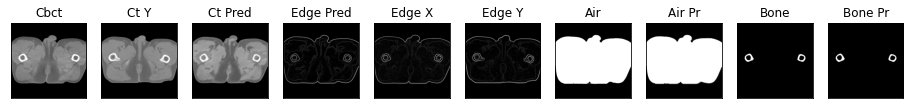

110it [00:43,  2.62it/s]

ssim score = 0.7631275057792664
psnr score = 21.704513549804688
snr score = 13.506111145019531
mae error = 0.03952247276902199
air dice score = 0.9975674532292954
bone dice score = 0.9540860525569135
contour dice score = 0.5591111183166504


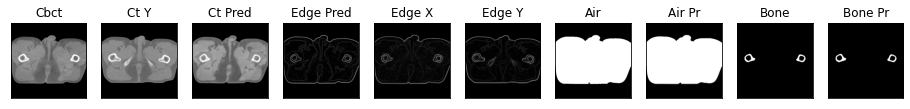

111it [00:43,  2.64it/s]

ssim score = 0.7591179013252258
psnr score = 21.396615982055664
snr score = 13.326168060302734
mae error = 0.04095225781202316
air dice score = 0.9980267356821241
bone dice score = 0.9288474653346477
contour dice score = 0.5485458374023438


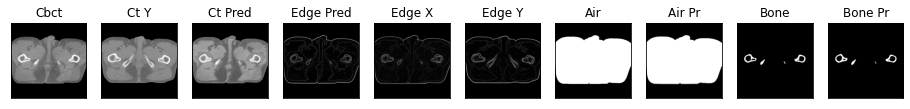

112it [00:44,  2.65it/s]

ssim score = 0.7548233270645142
psnr score = 21.3424129486084
snr score = 13.3042573928833
mae error = 0.04056641086935997
air dice score = 0.9982418121601188
bone dice score = 0.9357734806640923
contour dice score = 0.5188171863555908


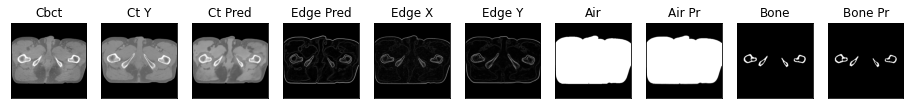

113it [00:44,  2.26it/s]

ssim score = 0.746276319026947
psnr score = 21.27018165588379
snr score = 13.262263298034668
mae error = 0.040875282138586044
air dice score = 0.9982175726368285
bone dice score = 0.9140611652158882
contour dice score = 0.5177847743034363


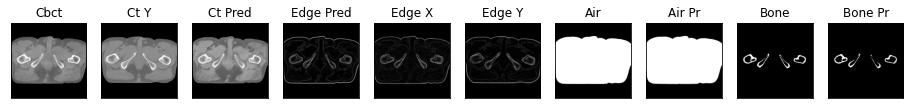

114it [00:45,  2.37it/s]

ssim score = 0.7419071197509766
psnr score = 21.140914916992188
snr score = 13.167410850524902
mae error = 0.04216096177697182
air dice score = 0.9979557703029188
bone dice score = 0.9125549584772422
contour dice score = 0.5184851288795471


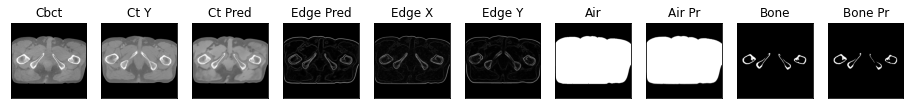

115it [00:45,  2.45it/s]

ssim score = 0.7358635663986206
psnr score = 20.880096435546875
snr score = 12.92690372467041
mae error = 0.04326411709189415
air dice score = 0.9980497798045161
bone dice score = 0.9107168613888545
contour dice score = 0.510580837726593


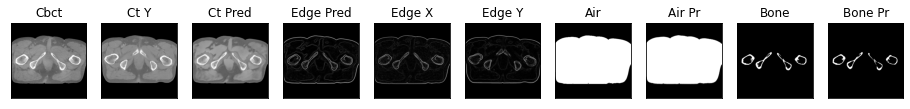

116it [00:45,  2.51it/s]

ssim score = 0.7376908659934998
psnr score = 20.906543731689453
snr score = 12.992425918579102
mae error = 0.043066639453172684
air dice score = 0.9974810209953449
bone dice score = 0.9080178494327333
contour dice score = 0.5291479825973511


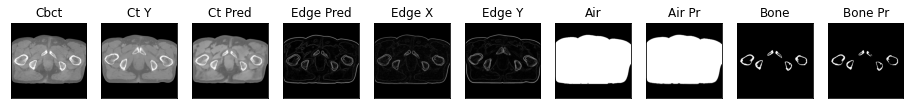

117it [00:46,  2.53it/s]

ssim score = 0.7354113459587097
psnr score = 20.886619567871094
snr score = 13.02117919921875
mae error = 0.04363985359668732
air dice score = 0.99697228834909
bone dice score = 0.9076751946620178
contour dice score = 0.5203816294670105


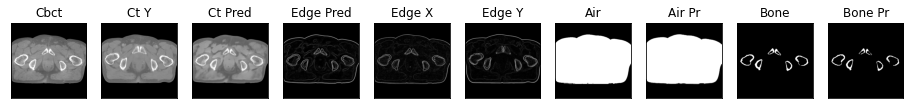

118it [00:46,  2.57it/s]

ssim score = 0.7275956273078918
psnr score = 20.61962127685547
snr score = 12.776793479919434
mae error = 0.04596797376871109
air dice score = 0.9968237835090858
bone dice score = 0.9007839956758478
contour dice score = 0.5212224125862122


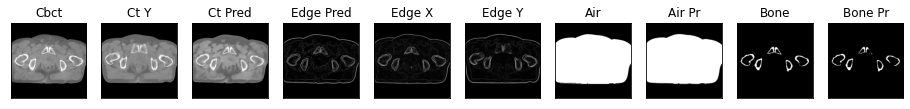

119it [00:47,  2.60it/s]

ssim score = 0.7181493043899536
psnr score = 20.559938430786133
snr score = 12.759889602661133
mae error = 0.04733886569738388
air dice score = 0.9975046823224334
bone dice score = 0.876075510467753
contour dice score = 0.488095223903656


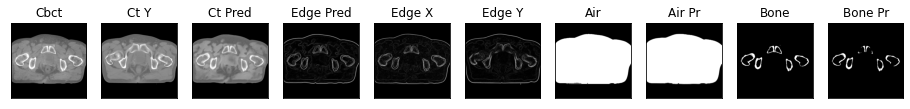

120it [00:47,  2.62it/s]

ssim score = 0.7225192785263062
psnr score = 20.6496524810791
snr score = 12.907942771911621
mae error = 0.047053173184394836
air dice score = 0.9978112127949275
bone dice score = 0.8786669795836813
contour dice score = 0.4857272207736969


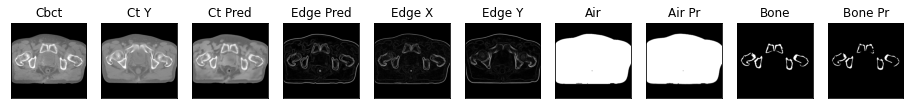

121it [00:47,  2.61it/s]

ssim score = 0.7154187560081482
psnr score = 20.559141159057617
snr score = 12.742059707641602
mae error = 0.048195015639066696
air dice score = 0.9983412254268915
bone dice score = 0.828758750974233
contour dice score = 0.46855059266090393


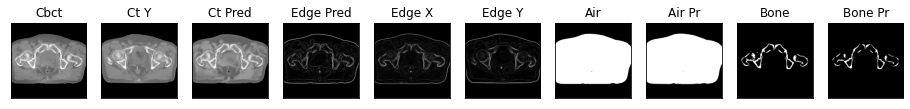

122it [00:48,  2.62it/s]

ssim score = 0.7200574278831482
psnr score = 20.602203369140625
snr score = 12.677900314331055
mae error = 0.047522783279418945
air dice score = 0.9982953664962043
bone dice score = 0.81145741879048
contour dice score = 0.4698905050754547


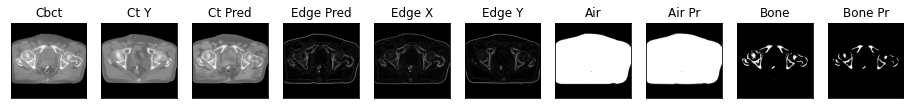

123it [00:48,  2.26it/s]

ssim score = 0.7263478636741638
psnr score = 20.928220748901367
snr score = 12.88083267211914
mae error = 0.04565922170877457
air dice score = 0.9985809898601106
bone dice score = 0.7853750138099482
contour dice score = 0.45483723282814026


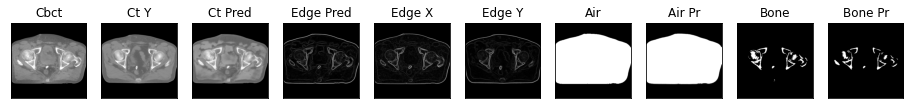

124it [00:49,  2.37it/s]

ssim score = 0.7301967740058899
psnr score = 20.941680908203125
snr score = 12.78186321258545
mae error = 0.04514460638165474
air dice score = 0.9986468511939387
bone dice score = 0.857582755967694
contour dice score = 0.47491946816444397


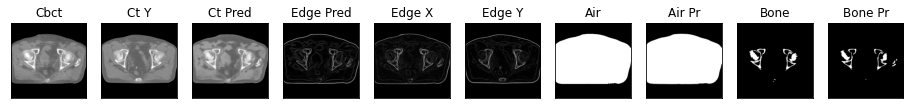

125it [00:49,  2.43it/s]

ssim score = 0.7275962233543396
psnr score = 21.258567810058594
snr score = 13.048103332519531
mae error = 0.04202349856495857
air dice score = 0.9984062824806569
bone dice score = 0.9066381156326913
contour dice score = 0.4838411808013916


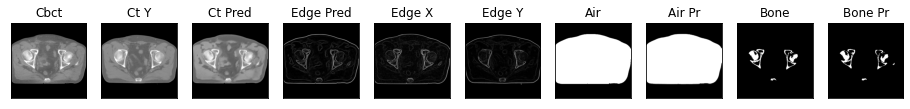

126it [00:49,  2.50it/s]

ssim score = 0.7248977422714233
psnr score = 21.005001068115234
snr score = 12.826690673828125
mae error = 0.04361410439014435
air dice score = 0.9983429511692054
bone dice score = 0.907143670959244
contour dice score = 0.4798143804073334


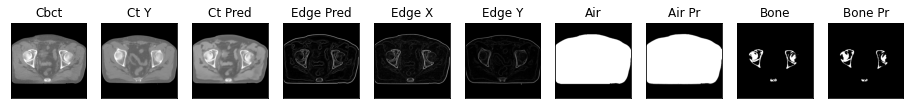

127it [00:50,  2.54it/s]

ssim score = 0.7266226410865784
psnr score = 20.786136627197266
snr score = 12.621305465698242
mae error = 0.044712767004966736
air dice score = 0.9983074802393965
bone dice score = 0.9021456033746478
contour dice score = 0.4700934588909149


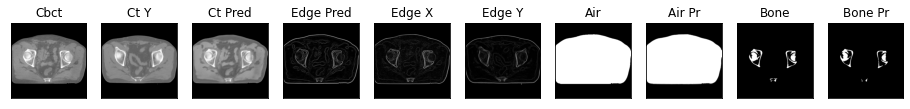

128it [00:50,  2.58it/s]

ssim score = 0.7237372398376465
psnr score = 20.63665008544922
snr score = 12.330322265625
mae error = 0.04470210149884224
air dice score = 0.9981413725788174
bone dice score = 0.8991239048823639
contour dice score = 0.4503061771392822


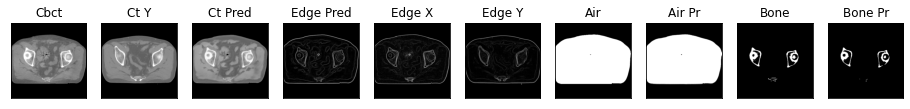

129it [00:51,  2.58it/s]

ssim score = 0.7325736880302429
psnr score = 20.655248641967773
snr score = 12.2896146774292
mae error = 0.04471011459827423
air dice score = 0.998407690093013
bone dice score = 0.9185779816525433
contour dice score = 0.436879426240921


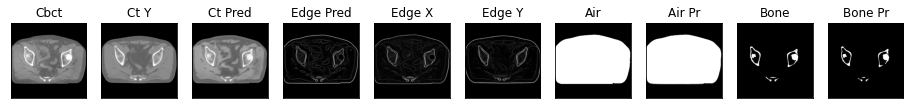

130it [00:51,  2.61it/s]

ssim score = 0.7260278463363647
psnr score = 20.77701187133789
snr score = 12.43702507019043
mae error = 0.044387783855199814
air dice score = 0.9983000023611088
bone dice score = 0.907905138341741
contour dice score = 0.45652174949645996


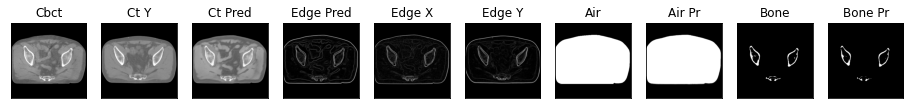

131it [00:51,  2.63it/s]

ssim score = 0.723473072052002
psnr score = 20.710433959960938
snr score = 12.443262100219727
mae error = 0.044481344521045685
air dice score = 0.9982202183198872
bone dice score = 0.9155571767296087
contour dice score = 0.42688122391700745


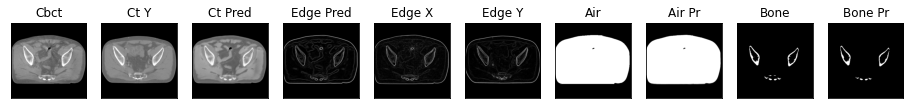

132it [00:52,  2.64it/s]

ssim score = 0.7177983522415161
psnr score = 20.370033264160156
snr score = 12.232091903686523
mae error = 0.04620303586125374
air dice score = 0.9979290382262553
bone dice score = 0.915760869566648
contour dice score = 0.4657142758369446


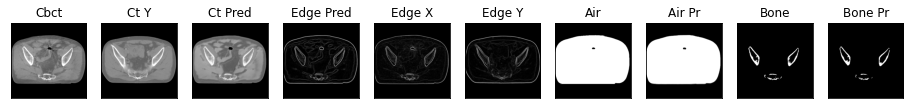

133it [00:52,  2.25it/s]

ssim score = 0.7117480635643005
psnr score = 20.253997802734375
snr score = 12.150014877319336
mae error = 0.046597398817539215
air dice score = 0.998103127438623
bone dice score = 0.905024413294928
contour dice score = 0.4647819697856903


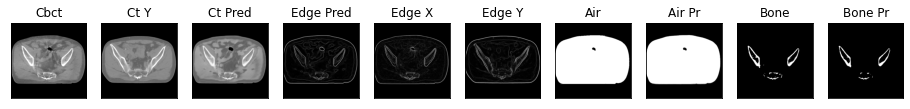

134it [00:53,  2.36it/s]

ssim score = 0.7054704427719116
psnr score = 20.27655792236328
snr score = 12.142784118652344
mae error = 0.04677380993962288
air dice score = 0.9979596135905396
bone dice score = 0.8839215686289683
contour dice score = 0.4359961450099945


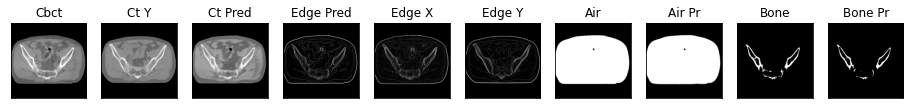

135it [00:53,  2.45it/s]

ssim score = 0.7030737400054932
psnr score = 20.550004959106445
snr score = 12.352856636047363
mae error = 0.04571785777807236
air dice score = 0.9980611375867516
bone dice score = 0.8545925712661302
contour dice score = 0.4534491002559662


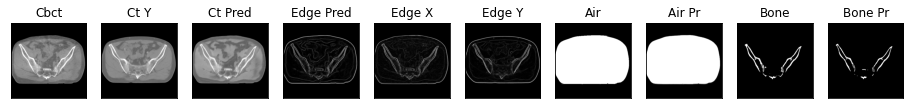

136it [00:53,  2.51it/s]

ssim score = 0.8108998537063599
psnr score = 22.341995239257812
snr score = 13.819387435913086
mae error = 0.03197441250085831
air dice score = 0.9977636918337743
bone dice score = 0.897077509531168
contour dice score = 0.4509018063545227


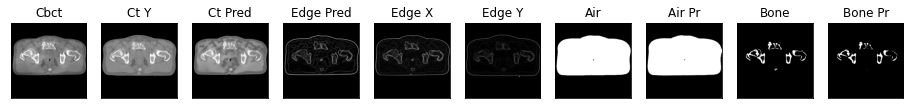

137it [00:54,  2.53it/s]

ssim score = 0.815643846988678
psnr score = 22.338716506958008
snr score = 13.856121063232422
mae error = 0.03204935044050217
air dice score = 0.997929790975671
bone dice score = 0.895298301068151
contour dice score = 0.4639435112476349


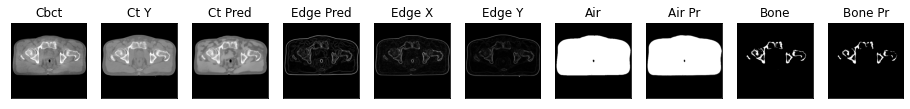

138it [00:54,  2.57it/s]

ssim score = 0.8178792595863342
psnr score = 22.485904693603516
snr score = 14.011096000671387
mae error = 0.0316765196621418
air dice score = 0.9979281921805978
bone dice score = 0.8792723263522703
contour dice score = 0.4398382306098938


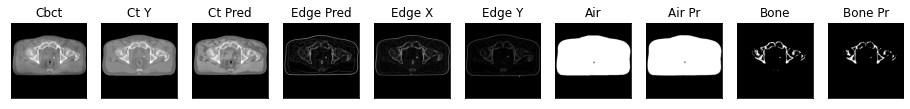

139it [00:54,  2.60it/s]

ssim score = 0.8225581049919128
psnr score = 22.455923080444336
snr score = 13.922693252563477
mae error = 0.031497303396463394
air dice score = 0.9979812126133255
bone dice score = 0.9041586692270741
contour dice score = 0.43270695209503174


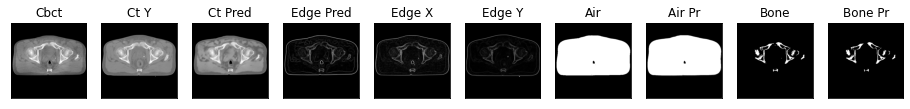

140it [00:55,  2.63it/s]

ssim score = 0.824954628944397
psnr score = 22.648374557495117
snr score = 13.959522247314453
mae error = 0.029710564762353897
air dice score = 0.9980725843804643
bone dice score = 0.9048118722844429
contour dice score = 0.45699745416641235


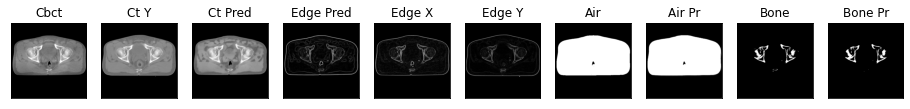

141it [00:55,  2.62it/s]

ssim score = 0.8279029726982117
psnr score = 22.802698135375977
snr score = 14.093042373657227
mae error = 0.028771499171853065
air dice score = 0.9978576458074294
bone dice score = 0.9175777964687752
contour dice score = 0.4384261667728424


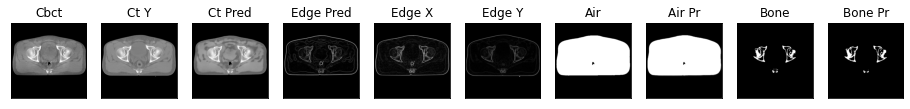

142it [00:56,  2.63it/s]

ssim score = 0.8211471438407898
psnr score = 22.689834594726562
snr score = 13.964546203613281
mae error = 0.02939305640757084
air dice score = 0.9980232252245496
bone dice score = 0.9274604267043708
contour dice score = 0.45230770111083984


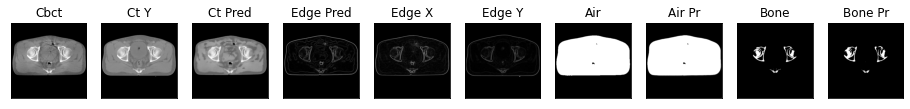

143it [00:56,  2.27it/s]

ssim score = 0.8180069923400879
psnr score = 22.291593551635742
snr score = 13.575672149658203
mae error = 0.0306033194065094
air dice score = 0.9980218054423017
bone dice score = 0.9209197980942103
contour dice score = 0.49252963066101074


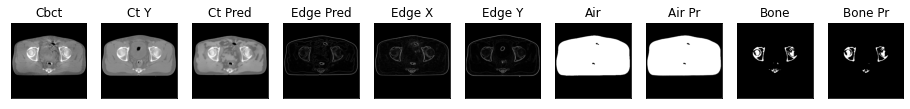

144it [00:57,  2.38it/s]

ssim score = 0.8139346241950989
psnr score = 22.274192810058594
snr score = 13.614051818847656
mae error = 0.03131139650940895
air dice score = 0.9979359306835639
bone dice score = 0.9285416955747392
contour dice score = 0.49715763330459595


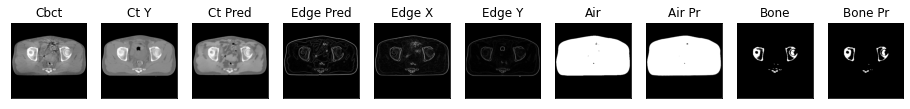

145it [00:57,  2.44it/s]

ssim score = 0.8100002408027649
psnr score = 21.886823654174805
snr score = 13.204751968383789
mae error = 0.03269696980714798
air dice score = 0.9976077826803484
bone dice score = 0.9324382231119491
contour dice score = 0.5106382966041565


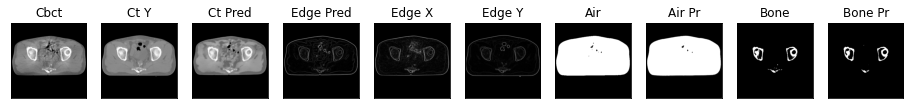

146it [00:57,  2.50it/s]

ssim score = 0.8091686367988586
psnr score = 21.4503173828125
snr score = 12.697469711303711
mae error = 0.03305778279900551
air dice score = 0.997386527281457
bone dice score = 0.9115341545366896
contour dice score = 0.490093857049942


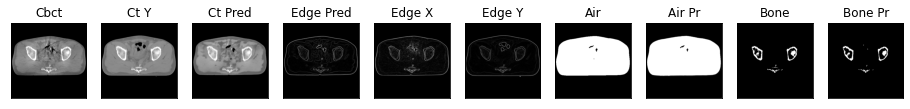

147it [00:58,  2.54it/s]

ssim score = 0.8092682957649231
psnr score = 21.700763702392578
snr score = 12.904024124145508
mae error = 0.032400693744421005
air dice score = 0.9974537637031748
bone dice score = 0.9265763505615224
contour dice score = 0.48218029737472534


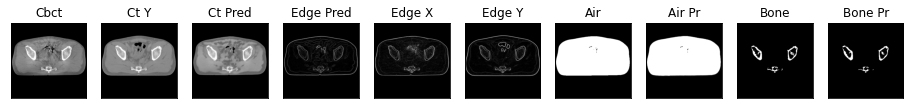

148it [00:58,  2.57it/s]

ssim score = 0.8073171377182007
psnr score = 21.885469436645508
snr score = 13.087634086608887
mae error = 0.032039690762758255
air dice score = 0.9974815325142592
bone dice score = 0.9254314555531515
contour dice score = 0.5


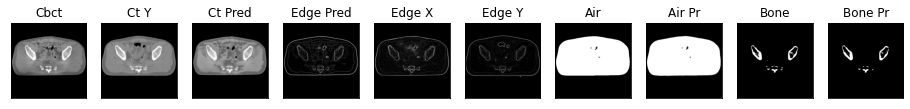

149it [00:58,  2.59it/s]

ssim score = 0.8054189085960388
psnr score = 21.817363739013672
snr score = 13.032886505126953
mae error = 0.03266752138733864
air dice score = 0.9972173110923228
bone dice score = 0.9258736875109563
contour dice score = 0.4678609073162079


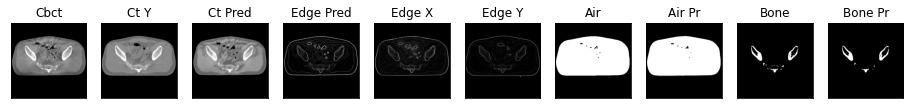

150it [00:59,  2.62it/s]

ssim score = 0.8061479330062866
psnr score = 21.718273162841797
snr score = 12.988997459411621
mae error = 0.03316076099872589
air dice score = 0.9973968592372895
bone dice score = 0.923463317912446
contour dice score = 0.4458531439304352


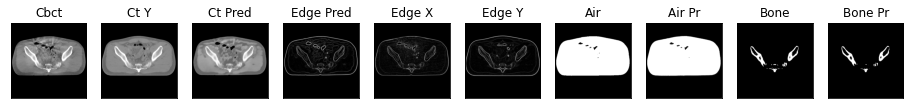

151it [00:59,  2.63it/s]

ssim score = 0.806885302066803
psnr score = 21.359365463256836
snr score = 12.649459838867188
mae error = 0.03415415808558464
air dice score = 0.9972139673105519
bone dice score = 0.9050186644558963
contour dice score = 0.43915343284606934


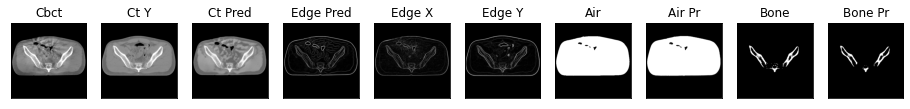

152it [01:00,  2.64it/s]

ssim score = 0.8123564124107361
psnr score = 21.621971130371094
snr score = 12.857328414916992
mae error = 0.03299859166145325
air dice score = 0.9971772166582907
bone dice score = 0.8994100741204143
contour dice score = 0.41507431864738464


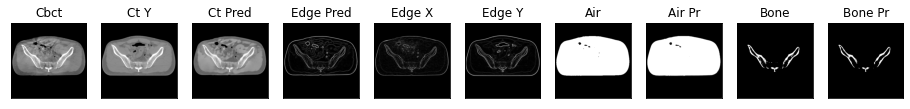

153it [01:00,  2.26it/s]

ssim score = 0.8157767057418823
psnr score = 21.935775756835938
snr score = 13.134780883789062
mae error = 0.03202347457408905
air dice score = 0.9971243931851232
bone dice score = 0.8854752851728445
contour dice score = 0.4208844006061554


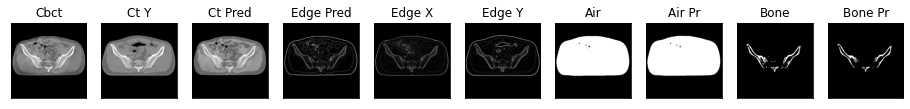

154it [01:01,  2.37it/s]

ssim score = 0.8211183547973633
psnr score = 22.128883361816406
snr score = 13.327960968017578
mae error = 0.030988063663244247
air dice score = 0.9972381460765449
bone dice score = 0.8754487710594387
contour dice score = 0.39614561200141907


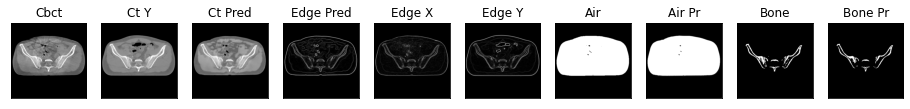

155it [01:01,  2.45it/s]

ssim score = 0.8193448781967163
psnr score = 22.200878143310547
snr score = 13.398530960083008
mae error = 0.031214693561196327
air dice score = 0.9975048044138635
bone dice score = 0.8895933838747127
contour dice score = 0.41505375504493713


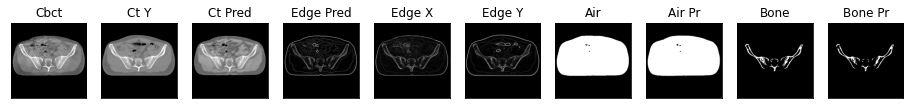

156it [01:01,  2.51it/s]

ssim score = 0.8106040358543396
psnr score = 21.63001251220703
snr score = 12.832706451416016
mae error = 0.03293995186686516
air dice score = 0.9971698259909518
bone dice score = 0.8772816624560899
contour dice score = 0.40864863991737366


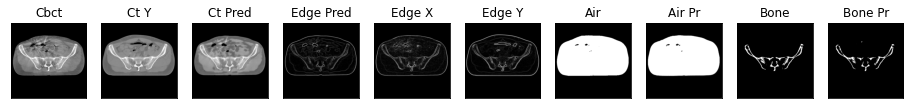

157it [01:02,  2.54it/s]

ssim score = 0.806300938129425
psnr score = 21.238964080810547
snr score = 12.424384117126465
mae error = 0.03460759297013283
air dice score = 0.9964011085522492
bone dice score = 0.8768886401807934
contour dice score = 0.4093630909919739


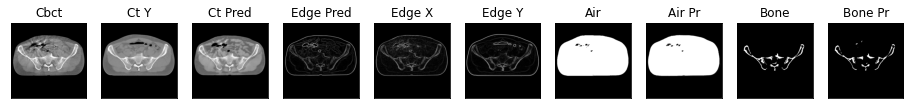

158it [01:02,  2.58it/s]

ssim score = 0.7999076247215271
psnr score = 20.90034294128418
snr score = 12.067138671875
mae error = 0.035956598818302155
air dice score = 0.9966206415292603
bone dice score = 0.8644338118040347
contour dice score = 0.3958333432674408


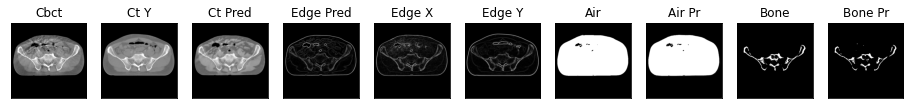

159it [01:02,  2.61it/s]

ssim score = 0.7918680310249329
psnr score = 20.594886779785156
snr score = 11.715744972229004
mae error = 0.03736144304275513
air dice score = 0.996309091910697
bone dice score = 0.8725140234590449
contour dice score = 0.39602866768836975


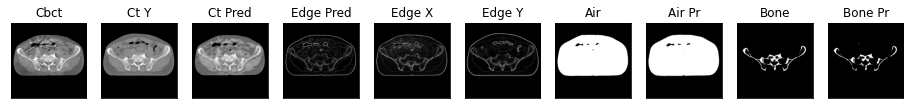

160it [01:03,  2.63it/s]

ssim score = 0.7851623296737671
psnr score = 20.628740310668945
snr score = 11.695799827575684
mae error = 0.037344831973314285
air dice score = 0.9961913491474026
bone dice score = 0.8859292144544836
contour dice score = 0.39689579606056213


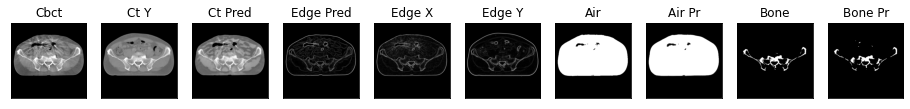

161it [01:03,  2.62it/s]

ssim score = 0.7818842530250549
psnr score = 20.338743209838867
snr score = 11.436266899108887
mae error = 0.038644447922706604
air dice score = 0.9957064514336994
bone dice score = 0.8930176077730051
contour dice score = 0.40445682406425476


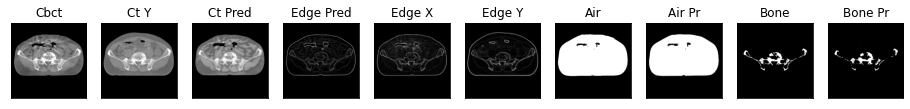

162it [01:04,  2.63it/s]

ssim score = 0.7708902955055237
psnr score = 20.125743865966797
snr score = 11.168042182922363
mae error = 0.03907431289553642
air dice score = 0.9958242859529013
bone dice score = 0.8900837814194063
contour dice score = 0.4104560613632202


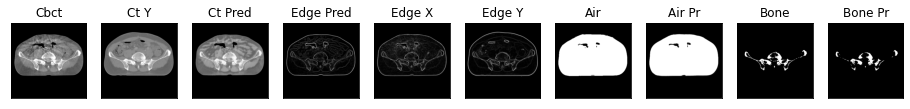

163it [01:04,  2.27it/s]

ssim score = 0.7761133909225464
psnr score = 20.774145126342773
snr score = 11.66891098022461
mae error = 0.03638487681746483
air dice score = 0.9966238274966982
bone dice score = 0.9126703685018592
contour dice score = 0.3657718002796173


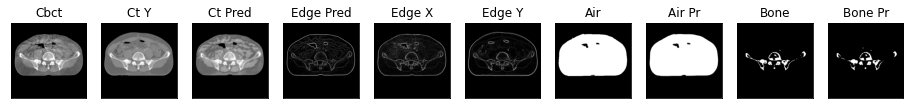

164it [01:05,  2.38it/s]

ssim score = 0.8371491432189941
psnr score = 24.045150756835938
snr score = 14.426060676574707
mae error = 0.02811257727444172
air dice score = 0.9957547795580874
bone dice score = 0.9082638362418938
contour dice score = 0.4733268618583679


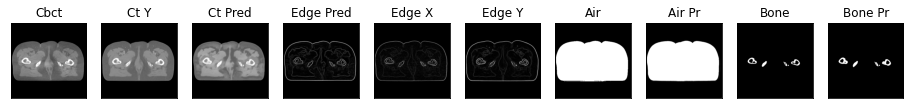

165it [01:05,  2.44it/s]

ssim score = 0.8380894064903259
psnr score = 24.33887481689453
snr score = 14.840797424316406
mae error = 0.026808639988303185
air dice score = 0.9960745254277038
bone dice score = 0.9076460481119492
contour dice score = 0.4399406909942627


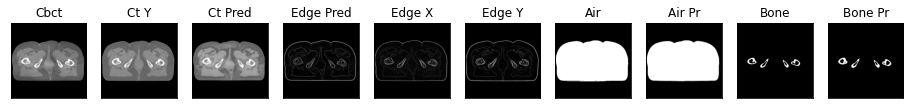

166it [01:05,  2.51it/s]

ssim score = 0.8330748677253723
psnr score = 24.42592430114746
snr score = 15.010765075683594
mae error = 0.026302535086870193
air dice score = 0.9961725969584544
bone dice score = 0.8989587350578682
contour dice score = 0.43771374225616455


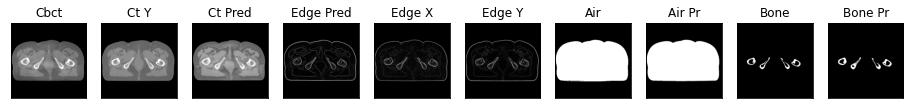

167it [01:06,  2.55it/s]

ssim score = 0.8296648859977722
psnr score = 24.399564743041992
snr score = 15.047850608825684
mae error = 0.026362979784607887
air dice score = 0.9960967767631518
bone dice score = 0.9118919854611063
contour dice score = 0.4529038667678833


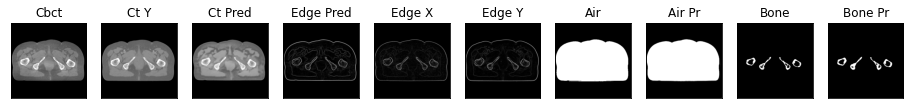

168it [01:06,  2.59it/s]

ssim score = 0.8288630247116089
psnr score = 24.36078643798828
snr score = 15.037534713745117
mae error = 0.026215195655822754
air dice score = 0.9963128918905295
bone dice score = 0.9341438703151952
contour dice score = 0.44247788190841675


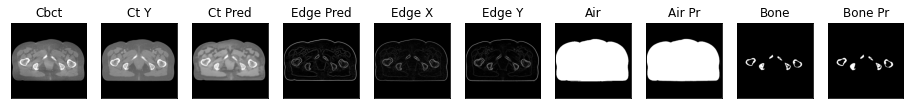

169it [01:06,  2.59it/s]

ssim score = 0.8287390470504761
psnr score = 24.250041961669922
snr score = 14.949745178222656
mae error = 0.026410071179270744
air dice score = 0.9961929025339895
bone dice score = 0.9337328163564728
contour dice score = 0.4294060468673706


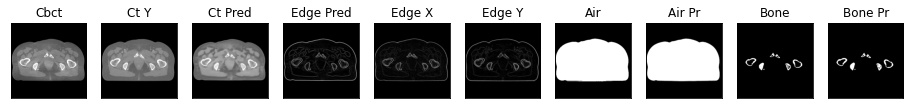

170it [01:07,  2.62it/s]

ssim score = 0.8269770741462708
psnr score = 24.220260620117188
snr score = 14.951290130615234
mae error = 0.026386095210909843
air dice score = 0.9959425202335414
bone dice score = 0.932167832169018
contour dice score = 0.4330594539642334


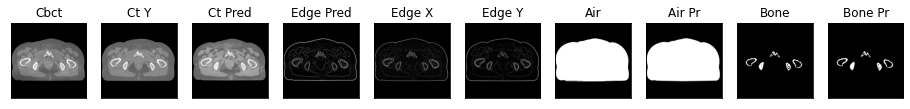

171it [01:07,  2.63it/s]

ssim score = 0.824893593788147
psnr score = 24.033645629882812
snr score = 14.813039779663086
mae error = 0.026753738522529602
air dice score = 0.9957531062584323
bone dice score = 0.9250725379770426
contour dice score = 0.4370300769805908


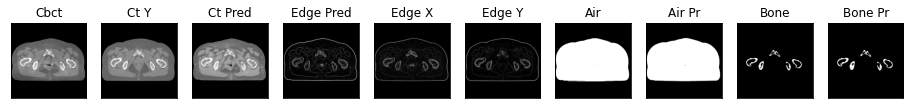

172it [01:08,  2.64it/s]

ssim score = 0.8254119753837585
psnr score = 23.775053024291992
snr score = 14.597190856933594
mae error = 0.026867937296628952
air dice score = 0.9960886758194073
bone dice score = 0.9289191820848925
contour dice score = 0.4190293252468109


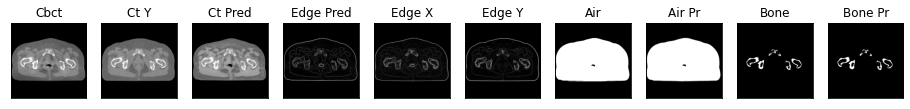

173it [01:08,  2.25it/s]

ssim score = 0.8245775699615479
psnr score = 23.70399284362793
snr score = 14.613832473754883
mae error = 0.026695510372519493
air dice score = 0.9957082161106995
bone dice score = 0.9224384659427242
contour dice score = 0.42783746123313904


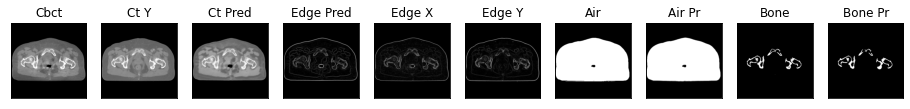

174it [01:09,  2.36it/s]

ssim score = 0.8266113996505737
psnr score = 24.457304000854492
snr score = 15.480415344238281
mae error = 0.02522093988955021
air dice score = 0.9954206108233646
bone dice score = 0.9255916077101048
contour dice score = 0.39575645327568054


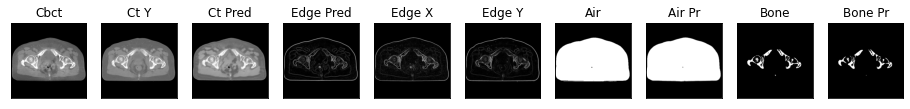

175it [01:09,  2.45it/s]

ssim score = 0.8261724710464478
psnr score = 23.816253662109375
snr score = 14.710816383361816
mae error = 0.026659229770302773
air dice score = 0.9953069780086168
bone dice score = 0.910887827377518
contour dice score = 0.4459833800792694


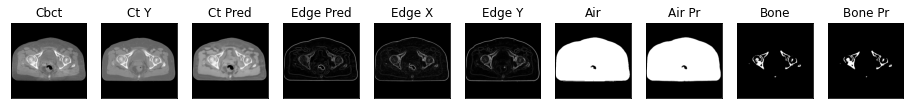

176it [01:09,  2.51it/s]

ssim score = 0.8311792612075806
psnr score = 23.86345100402832
snr score = 14.648590087890625
mae error = 0.027107419446110725
air dice score = 0.9955417107256184
bone dice score = 0.8964761730893468
contour dice score = 0.4498366713523865


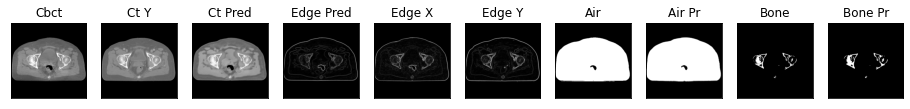

177it [01:10,  2.56it/s]

ssim score = 0.8356537222862244
psnr score = 23.770000457763672
snr score = 14.5280122756958
mae error = 0.027752839028835297
air dice score = 0.9955557454809655
bone dice score = 0.9115352697110118
contour dice score = 0.4743589758872986


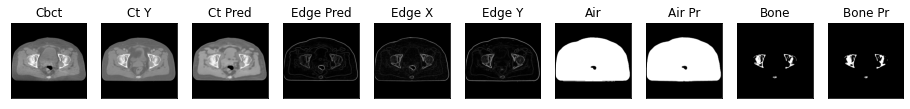

178it [01:10,  2.60it/s]

ssim score = 0.8403404951095581
psnr score = 24.16777801513672
snr score = 14.917787551879883
mae error = 0.027505481615662575
air dice score = 0.9961578664858631
bone dice score = 0.9322170342950858
contour dice score = 0.4624708592891693


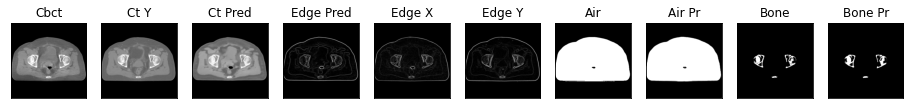

179it [01:10,  2.62it/s]

ssim score = 0.8390986919403076
psnr score = 24.752750396728516
snr score = 15.536985397338867
mae error = 0.026003476232290268
air dice score = 0.9968069910091611
bone dice score = 0.9352008619372757
contour dice score = 0.42541176080703735


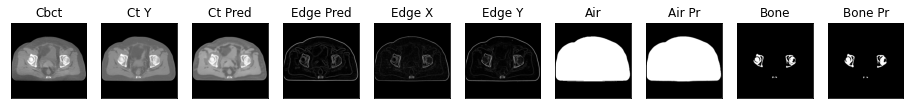

180it [01:11,  2.64it/s]

ssim score = 0.833743155002594
psnr score = 24.482877731323242
snr score = 15.318604469299316
mae error = 0.02665078267455101
air dice score = 0.9971570964849499
bone dice score = 0.9530708661424713
contour dice score = 0.45139557123184204


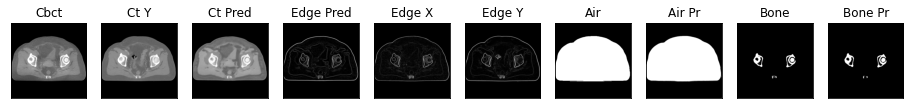

181it [01:11,  2.64it/s]

ssim score = 0.8213635683059692
psnr score = 23.8217716217041
snr score = 14.695060729980469
mae error = 0.02821749821305275
air dice score = 0.997256496863585
bone dice score = 0.95199182839714
contour dice score = 0.4519555866718292


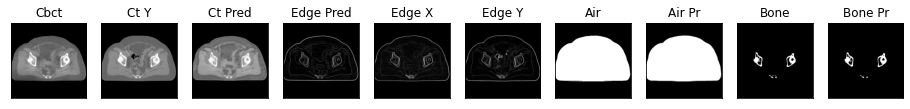

182it [01:12,  2.66it/s]

ssim score = 0.8056716322898865
psnr score = 22.405080795288086
snr score = 13.20592975616455
mae error = 0.03191728517413139
air dice score = 0.9972504924491155
bone dice score = 0.9201440372819287
contour dice score = 0.43988269567489624


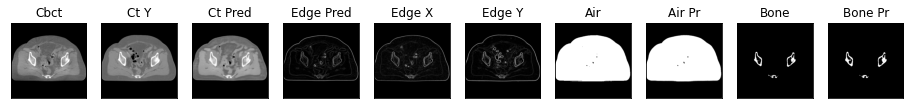

183it [01:12,  2.28it/s]

ssim score = 0.7952980995178223
psnr score = 22.154956817626953
snr score = 12.937811851501465
mae error = 0.03328383341431618
air dice score = 0.9973742568330562
bone dice score = 0.9335340933548391
contour dice score = 0.41382715106010437


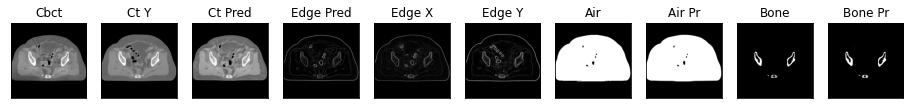

184it [01:12,  2.38it/s]

ssim score = 0.7905479669570923
psnr score = 22.59965705871582
snr score = 13.447427749633789
mae error = 0.032984331250190735
air dice score = 0.9975841672106233
bone dice score = 0.9351735675463159
contour dice score = 0.4158024787902832


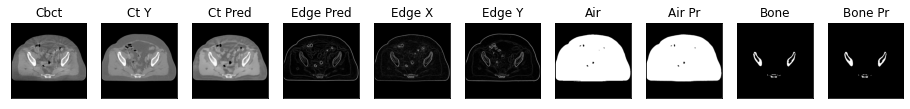

185it [01:13,  2.46it/s]

ssim score = 0.7907939553260803
psnr score = 22.83051300048828
snr score = 13.733378410339355
mae error = 0.03216688707470894
air dice score = 0.9973855162938376
bone dice score = 0.9339253996459338
contour dice score = 0.42330676317214966


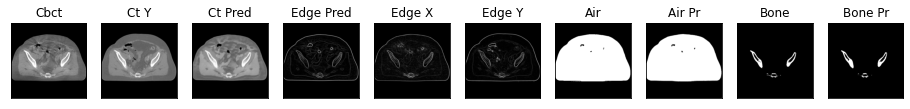

186it [01:13,  2.53it/s]

ssim score = 0.7854058146476746
psnr score = 22.394287109375
snr score = 13.36158275604248
mae error = 0.03297542780637741
air dice score = 0.9974762823392633
bone dice score = 0.9344899790617037
contour dice score = 0.40314650535583496


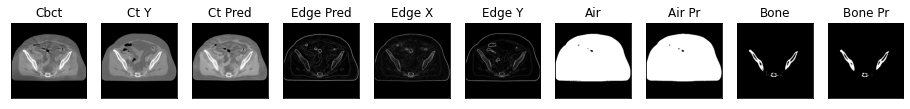

187it [01:14,  2.57it/s]

ssim score = 0.7864412069320679
psnr score = 22.30091094970703
snr score = 13.341065406799316
mae error = 0.03307793289422989
air dice score = 0.9973981033025099
bone dice score = 0.9251570609133412
contour dice score = 0.4000000059604645


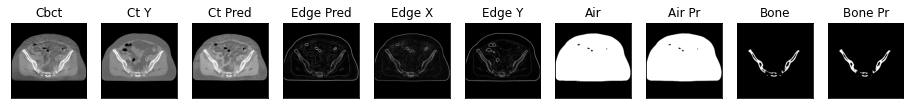

188it [01:14,  2.60it/s]

ssim score = 0.7867067456245422
psnr score = 22.247941970825195
snr score = 13.283804893493652
mae error = 0.033403974026441574
air dice score = 0.9973675144786721
bone dice score = 0.9143974305276582
contour dice score = 0.3921951353549957


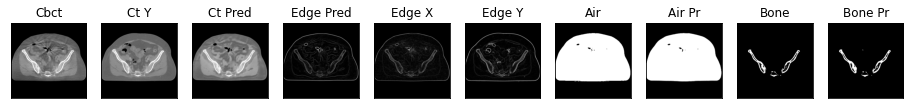

189it [01:14,  2.62it/s]

ssim score = 0.7828325629234314
psnr score = 22.36410903930664
snr score = 13.37779426574707
mae error = 0.03286128118634224
air dice score = 0.9976107830320531
bone dice score = 0.9174908548988282
contour dice score = 0.3930130898952484


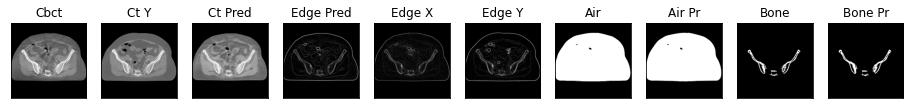

190it [01:15,  2.64it/s]

ssim score = 0.7896915674209595
psnr score = 22.90586280822754
snr score = 13.931184768676758
mae error = 0.031770218163728714
air dice score = 0.9975178504201804
bone dice score = 0.9142205756638042
contour dice score = 0.44262295961380005


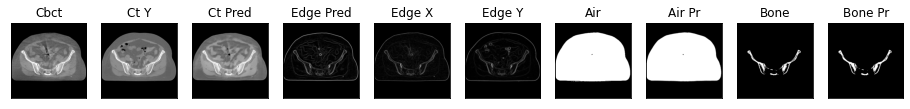

191it [01:15,  2.52it/s]


In [43]:
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=4)
test_epoch(model, testloader, device, True, os.path.join("eval-gan", wandb.run.name))

In [44]:
tf_discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)
replace_relu_to_leakyReLU(tf_discriminator)
replace_bn_to_instanceNorm(tf_discriminator)
tf_discriminator.load_state_dict(checkpoint["tf_discriminator"])

<All keys matched successfully>

In [45]:
edge_discriminator = Discriminator(in_channel=E_IN_CHANNELS, n_classes=E_N_CLASSES, activation=E_ACT)
replace_relu_to_leakyReLU(edge_discriminator)
replace_bn_to_instanceNorm(edge_discriminator)
edge_discriminator.load_state_dict(checkpoint["edge_discriminator"])

<All keys matched successfully>

In [46]:
# score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, \
#             score_air_test, score_bone_test, score_cont_test, score_tf_acc_test, score_edge_acc_test
eval_epoch(model, tf_discriminator, edge_discriminator, testloader, device)

191it [00:09, 19.65it/s]


(0.8172523550962278,
 23.029129267987155,
 14.033401199660377,
 0.03048919842466322,
 0.9971587533812503,
 0.908727132931051,
 0.45368000552916404,
 0.47643979057591623,
 0.7172774869109948)

In [47]:
# import torchvision.models as models
# models.vgg16(pretrained=True)